<a href="https://colab.research.google.com/github/alliwene/gb-november-grp2-health-insurance/blob/main/dhs_1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # <center> <b>  ANALYSIS AND PREDICTION OF HEALTH INSURANCE SUBSCRIPTION IN NIGERIA </b> </center> 

## Problem Statement

  Robust health care plays a significant role in the survival and viability of a country's social and economic development, especially in low and middle-income nations where disease prevalence is highest. The National Health Insurance Scheme (NHIS) started operations in 2015, to provide all Nigerians with access to appropriate and affordable health care, but a good amount of the Nigerian population still has no health insurance coverage.

  Our project deals with predicting whether an individual would take up a health insurance policy or not using the Individual Recode section of the 2018 Nigerian Demographic and Health Survey [DHS](https://dhsprogram.com/data/dataset/Nigeria_Standard-DHS_2018.cfm) dataset leveraging machine learning classification models. This dataset contains questionnaires answers from different households in Nigeria, which includes age  groups, region, highest educational level, e.t.c. We would also investigate factors that most likely influence taking up a health policy using the trained ML model, this result would help insurance companies and public health stakeholders make smarter decisions on targeted ads to potential customers and improve health insurance penetration amongst the Nigerian populace. 


<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQk6MWvMt4EgDEKS4S6Y4z_HGlIYmUomW9Llg&usqp=CAU.png" width="480" height="240"/> </center>


Mount Google drive to access data and load required libraries

In [1]:
# Mount Google Drive 
from google.colab import drive # import drive from google colab
import os, random 
ROOT = "/content/drive"     # default location for the drive
 
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [2]:
# set file path
path = "/content/drive/MyDrive"
os.chdir(path)
!ls # list files in the path

 catboost_info	    insurance_count_plot.png   model_comparison.csv
'Colab Notebooks'   insurance_pie_chart.png    model_comprison.png
 data_clean.csv     insurance_rf.pkl	       NGIR7AFL.SAV
 insurance_cb.pkl   insurance_type_plot.png    presentation.pptx


In [4]:
# install pyreadstat to read the spss file
!pip install pyreadstat --quiet 

In [5]:
# import required libraries 

import pandas as pd
import numpy as np 
import pyreadstat
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
import pickle

import warnings
warnings.simplefilter(action='ignore')

## Data Cleaning



Read in the data to a dataframe and get corresponding metadata

In [6]:
df, meta = pyreadstat.read_sav('NGIR7AFL.SAV')
df.head() 

,CASEID,V000,V001,V002,V003,V004,V005,V006,V007,V008,V008A,V009,V010,V011,V012,V013,V014,V015,V016,V017,V018,V019,V019A,V020,V021,V022,V023,V024,V025,V026,V027,V028,V029,V030,V031,V032,V034,V040,V042,V044,...,S434IE$3,S434IE$4,S434IE$5,S434IE$6,S434IF$1,S434IF$2,S434IF$3,S434IF$4,S434IF$5,S434IF$6,S434IG$1,S434IG$2,S434IG$3,S434IG$4,S434IG$5,S434IG$6,S434IX$1,S434IX$2,S434IX$3,S434IX$4,S434IX$5,S434IX$6,S434IZ$1,S434IZ$2,S434IZ$3,S434IZ$4,S434IZ$5,S434IZ$6,S434K$1,S434K$2,S434K$3,S434K$4,S434K$5,S434K$6,S434L$1,S434L$2,S434L$3,S434L$4,S434L$5,S434L$6
0,1 1 2,NG7,1.0,1.0,2.0,1.0,1335530.0,9.0,2018.0,1425.0,43345.0,3.0,1978.0,939.0,40.0,6.0,1.0,1.0,2.0,1357.0,12.0,69.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,706.0,NaN,701.0,NaN,NaN,0.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 6 4,NG7,1.0,6.0,4.0,1.0,1335530.0,9.0,2018.0,1425.0,43344.0,6.0,2002.0,1230.0,16.0,1.0,1.0,1.0,1.0,1357.0,12.0,69.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,704.0,NaN,701.0,NaN,NaN,NaN,100.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 11 1,NG7,1.0,11.0,1.0,1.0,1335530.0,9.0,2018.0,1425.0,43345.0,5.0,1981.0,977.0,37.0,5.0,1.0,1.0,2.0,1357.0,12.0,69.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,704.0,NaN,701.0,NaN,NaN,0.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 25 2,NG7,1.0,25.0,2.0,1.0,1335530.0,9.0,2018.0,1425.0,43345.0,11.0,1990.0,1091.0,27.0,3.0,1.0,1.0,2.0,1357.0,12.0,69.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,705.0,NaN,701.0,NaN,NaN,1.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 30 1,NG7,1.0,30.0,1.0,1.0,1335530.0,9.0,2018.0,1425.0,43345.0,5.0,1989.0,1073.0,29.0,3.0,1.0,1.0,2.0,1357.0,12.0,69.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,705.0,NaN,701.0,NaN,NaN,NaN,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape 

(41821, 5394)

In [8]:
# check first 10 column labels from metadata
pprint(meta.column_labels[:10]) 

['Case Identification',
 'Country code and phase',
 'Cluster number',
 'Household number',
 "Respondent's line number",
 'Ultimate area unit',
 "Women's individual sample weight (6 decimals)",
 'Month of interview',
 'Year of interview',
 'Date of interview (CMC)']


In [9]:
# check if target column in column labels 
'Covered by health insurance' in meta.column_labels 

True

In [10]:
# get dictionary with column name as key and column label as value from metadata
# print first 10 items
labels_dict = meta.column_names_to_labels
pprint(list(labels_dict.items())[:10])  

[('CASEID', 'Case Identification'),
 ('V000', 'Country code and phase'),
 ('V001', 'Cluster number'),
 ('V002', 'Household number'),
 ('V003', "Respondent's line number"),
 ('V004', 'Ultimate area unit'),
 ('V005', "Women's individual sample weight (6 decimals)"),
 ('V006', 'Month of interview'),
 ('V007', 'Year of interview'),
 ('V008', 'Date of interview (CMC)')]


In [11]:
# get key from value in dict
print(list(labels_dict.keys())[list(labels_dict.values()).index(
    'Covered by health insurance')]) 

V481


In [12]:
# get variable names for column with categorical variables from metadata
# print first 5 items
variable_values = meta.variable_value_labels   
pprint(list(variable_values.items())[:5])

[('V013',
  {1.0: '15-19',
   2.0: '20-24',
   3.0: '25-29',
   4.0: '30-34',
   5.0: '35-39',
   6.0: '40-44',
   7.0: '45-49'}),
 ('V014',
  {1.0: 'Month and year - information complete',
   2.0: 'Month and age - year imputed',
   3.0: 'Year and age - month imputed',
   4.0: 'Year and age - year ignored',
   5.0: 'Year - age/month imputed',
   6.0: 'Age - year/month imputed',
   7.0: 'Month - age/year imputed',
   8.0: 'None - all imputed'}),
 ('V015',
  {1.0: 'Completed',
   2.0: 'Not at home',
   3.0: 'Postponed',
   4.0: 'Refused',
   5.0: 'Partially completed',
   6.0: 'Respondent incapacitated',
   7.0: 'Other'}),
 ('V018', {0.0: 'No calendar'}),
 ('V019', {0.0: 'No calendar'})]


In [13]:
# drop caseid column
df.drop('CASEID', axis=1, inplace=True)

### Drop columns with single unique values
Check and drop columns with one unique values, coulmns like this would be useless for a model

In [14]:
empty_unique = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    empty_unique.append(col) 

print(len(empty_unique)) # print list len

2904


In [15]:
# drop the columns
df.drop(empty_unique, axis=1, inplace=True)
df.head() 

,V001,V002,V003,V004,V005,V006,V008,V008A,V009,V010,V011,V012,V013,V014,V016,V018,V019,V021,V022,V023,V024,V025,V027,V028,V030,V034,V040,V042,V044,V045A,V045B,V045C,V046,V101,V102,V104,V105,V105A,V106,V107,...,S430EL$3,S430EL$4,S430EL$5,S430EL$6,S430EX$1,S430EX$2,S430EX$3,S430EX$4,S430EX$5,S430EX$6,S430EZ$1,S430EZ$2,S430EZ$3,S430EZ$4,S430EZ$5,S430EZ$6,S430G$1,S430G$2,S430G$3,S430G$4,S430G$5,S430G$6,S433A$1,S433A$2,S433A$3,S433A$4,S434C$1,S434E$1,S434H$1,S434IA$1,S434IB$1,S434IC$1,S434ID$1,S434IE$1,S434IF$1,S434IG$1,S434IX$1,S434IZ$1,S434K$1,S434L$1
0,1.0,1.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,3.0,1978.0,939.0,40.0,6.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,2.0,706.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,4.0,0.0,1.0,1.0,8.0,2.0,18.0,3.0,3.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,115.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,124.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,6.0,4.0,1.0,1335530.0,9.0,1425.0,43344.0,6.0,2002.0,1230.0,16.0,1.0,1.0,1.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,NaN,100.0,1.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,NaN,NaN,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,11.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1981.0,977.0,37.0,5.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,5.0,3.0,18.0,3.0,3.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1.0,25.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,11.0,1990.0,1091.0,27.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,1.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1.0,30.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1989.0,1073.0,29.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,NaN,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,NaN,NaN,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop columns with duplicate labels
Check and drop columns with duplicate labels in dataframe. 

In [16]:
duplicate_list = []
for col in df.columns:
  if '$' in col:
    duplicate_list.append(col)
print(duplicate_list)
print(len(duplicate_list))

['BIDX$01', 'BIDX$02', 'BIDX$03', 'BIDX$04', 'BIDX$05', 'BIDX$06', 'BIDX$07', 'BIDX$08', 'BIDX$09', 'BIDX$10', 'BIDX$11', 'BIDX$12', 'BIDX$13', 'BIDX$14', 'BIDX$15', 'BIDX$16', 'BIDX$17', 'BORD$01', 'BORD$02', 'BORD$03', 'BORD$04', 'BORD$05', 'BORD$06', 'BORD$07', 'BORD$08', 'BORD$09', 'BORD$10', 'BORD$11', 'BORD$12', 'BORD$13', 'BORD$14', 'BORD$15', 'BORD$16', 'BORD$17', 'B0$01', 'B0$02', 'B0$03', 'B0$04', 'B0$05', 'B0$06', 'B0$07', 'B0$08', 'B0$09', 'B0$10', 'B0$11', 'B0$12', 'B0$13', 'B0$14', 'B0$15', 'B0$16', 'B0$17', 'B1$01', 'B1$02', 'B1$03', 'B1$04', 'B1$05', 'B1$06', 'B1$07', 'B1$08', 'B1$09', 'B1$10', 'B1$11', 'B1$12', 'B1$13', 'B1$14', 'B1$15', 'B1$16', 'B1$17', 'B2$01', 'B2$02', 'B2$03', 'B2$04', 'B2$05', 'B2$06', 'B2$07', 'B2$08', 'B2$09', 'B2$10', 'B2$11', 'B2$12', 'B2$13', 'B2$14', 'B2$15', 'B2$16', 'B2$17', 'B3$01', 'B3$02', 'B3$03', 'B3$04', 'B3$05', 'B3$06', 'B3$07', 'B3$08', 'B3$09', 'B3$10', 'B3$11', 'B3$12', 'B3$13', 'B3$14', 'B3$15', 'B3$16', 'B3$17', 'B4$01', 'B4$

In [17]:
# drop duplicate column labels 
df.drop(duplicate_list, axis=1, inplace=True)
df.head()

,V001,V002,V003,V004,V005,V006,V008,V008A,V009,V010,V011,V012,V013,V014,V016,V018,V019,V021,V022,V023,V024,V025,V027,V028,V030,V034,V040,V042,V044,V045A,V045B,V045C,V046,V101,V102,V104,V105,V105A,V106,V107,...,S653T,S653U,S653V,S815E,S815F,S815G,S815H,S815I,S816A,S816B,S816C,S816D,S816E,S816X,S1108AB,S1108AC,S1108AD,S1108AF,S1108AI,S1108BA,S1108BC,S1108BD,S1108BF,S1205AA,S1205BA,S1205CA,S1205DA,S1205B,S1301,S1302,S1303,S1304,S1305,S1306,S1306A,S1307,S1309,S1310,S1311,S1312
0,1.0,1.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,3.0,1978.0,939.0,40.0,6.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,2.0,706.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,4.0,0.0,1.0,1.0,8.0,2.0,18.0,3.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,6.0,4.0,1.0,1335530.0,9.0,1425.0,43344.0,6.0,2002.0,1230.0,16.0,1.0,1.0,1.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,NaN,100.0,1.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,NaN,NaN,2.0,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,11.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1981.0,977.0,37.0,5.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,5.0,3.0,18.0,3.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,25.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,11.0,1990.0,1091.0,27.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,1.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,30.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1989.0,1073.0,29.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,NaN,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,NaN,NaN,2.0,6.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for missing values percentage in dataframe and filter the dataframe using a percentage threshold, $40 \%$ threshold was used  

In [18]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False)

S1305    99.976089
V833C    99.921092
S1304    99.904354
S1312    99.901963
S1311    99.901963
           ...    
S653D     0.000000
S653E     0.000000
S653F     0.000000
S653G     0.000000
V001      0.000000
Length: 598, dtype: float64

In [19]:
data = df.loc[:, percent_missing < 40]
data.head()

,V001,V002,V003,V004,V005,V006,V008,V008A,V009,V010,V011,V012,V013,V014,V016,V018,V019,V021,V022,V023,V024,V025,V027,V028,V030,V034,V040,V042,V044,V045A,V045B,V045C,V046,V101,V102,V104,V106,V107,V113,V115,...,S653E,S653F,S653G,S653H,S653I,S653J,S653K,S653L,S653M,S653N,S653O,S653P,S653Q,S653R,S653S,S653T,S653U,S653V,S815E,S815F,S815G,S815H,S815I,S816A,S816B,S816C,S816D,S816E,S816X,S1108AB,S1108AC,S1108AD,S1108AF,S1108AI,S1108BA,S1108BC,S1108BD,S1108BF,S1301,S1302
0,1.0,1.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,3.0,1978.0,939.0,40.0,6.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,2.0,706.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,4.0,0.0,1.0,1.0,8.0,3.0,3.0,14.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,6.0,4.0,1.0,1335530.0,9.0,1425.0,43344.0,6.0,2002.0,1230.0,16.0,1.0,1.0,1.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,NaN,100.0,1.0,1.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,2.0,4.0,92.0,996.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN
2,1.0,11.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1981.0,977.0,37.0,5.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,704.0,701.0,0.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,5.0,3.0,3.0,14.0,20.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,25.0,2.0,1.0,1335530.0,9.0,1425.0,43345.0,11.0,1990.0,1091.0,27.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,1.0,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,2.0,3.0,2.0,51.0,996.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,30.0,1.0,1.0,1335530.0,9.0,1425.0,43345.0,5.0,1989.0,1073.0,29.0,3.0,1.0,2.0,12.0,69.0,1.0,1.0,1.0,1.0,1.0,1.0,705.0,701.0,NaN,100.0,0.0,0.0,1.0,1.0,9.0,0.0,1.0,1.0,95.0,2.0,6.0,14.0,20.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [20]:
target = pd.DataFrame(data['V481'])
target.head()

,V481
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [21]:
data.drop('V481', axis = 1, inplace = True)

### Filter features with strong correlations 

Check for strong correlations among features ($r > 0.8$) and drop colums with the high correlations. We want our features to be independent

Calculate the correlation matrix among features and take the absolute value

In [22]:
corr_matrix = data.corr().abs()
print(corr_matrix)

             V001      V002      V003  ...   S1108BF     S1301     S1302
V001     1.000000  0.050589  0.121223  ...  0.059234  0.005461  0.201925
V002     0.050589  1.000000  0.021293  ...  0.015313  0.001937  0.003968
V003     0.121223  0.021293  1.000000  ...  0.030202  0.005030  0.044342
V004     1.000000  0.050589  0.121223  ...  0.059234  0.005461  0.201925
V005     0.175235  0.405343  0.006205  ...  0.007634  0.004891  0.078545
...           ...       ...       ...  ...       ...       ...       ...
S1108BC  0.150247  0.021897  0.006956  ...  0.418657  0.019434  0.143962
S1108BD  0.051509  0.014758  0.003024  ...  0.268804  0.004288  0.067390
S1108BF  0.059234  0.015313  0.030202  ...  1.000000  0.014903  0.087557
S1301    0.005461  0.001937  0.005030  ...  0.014903  1.000000       NaN
S1302    0.201925  0.003968  0.044342  ...  0.087557       NaN  1.000000

[316 rows x 316 columns]


Create a True/False mask and apply it

In [23]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

List column names of highly correlated features ($r > 0.8$)

In [24]:
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.8)]
print(len(to_drop))

88


Drop the features in the to_drop list

In [25]:
data.drop(to_drop, axis=1, inplace=True)
data.shape

(41821, 228)

### Filter with mean correlation of features with target. 
Find the mean correlation value of features with target. Create a filter with columns using this mean value, and use filter for the dataframe. Columns with decent correlation values with target may have a positive impact on our predictions

Find mean correlation of features with target variable

In [26]:
mean_corr = data.apply(lambda x: target.corrwith(x).abs()).mean(axis=1)['V481']
mean_corr 

0.03966458229621059

Create a filter with columns that has correlation greater than mean value with target column

In [27]:
filter = data.apply(lambda x: target.corrwith(x).abs()) > mean_corr
filter

,V002,V003,V005,V009,V014,V016,V019,V034,V040,V044,V045B,V045C,V046,V101,V102,V104,V107,V113,V115,V116,V127,V128,V129,V130,V131,V136,V137,V138,V140,V150,V151,V152,V155,V157,V158,V159,V161,V167,V169A,V170,...,S653D,S653E,S653F,S653G,S653H,S653I,S653J,S653K,S653L,S653M,S653N,S653O,S653P,S653Q,S653R,S653S,S653T,S653U,S653V,S815E,S815F,S815G,S815H,S815I,S816A,S816B,S816C,S816D,S816E,S816X,S1108AC,S1108AD,S1108AF,S1108AI,S1108BA,S1108BC,S1108BD,S1108BF,S1301,S1302
V481,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True,True,True,True,False,False,False,False,True,False,True,False,False,False,True,True,True,True,False,False,True,True,...,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False


Filter df1 with the filter

In [28]:
data = data.loc[:, [x for x in filter.iloc[0]]]
data.head()

,V102,V104,V107,V115,V116,V127,V128,V137,V140,V155,V157,V158,V159,V169A,V170,V171A,V171B,V191A,V212,V380,V384A,V384B,V384C,V384D,V394,V467B,V467C,V467D,V467F,V481A,V481B,V481C,V481D,V481X,V511,V525,V614,V715,V716,V717,V729,V732,V743A,V743B,V743D,V785,V857B,S653F,S653I,S653J,S653N,S653Q,S653T,S815E,S815F,S815G,S816A,S816B,S1108AI,S1301
0,1.0,8.0,3.0,10.0,11.0,33.0,31.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,115856.0,22.0,8.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,21.0,21.0,5.0,12.0,1.0,1.0,4.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,95.0,4.0,996.0,12.0,33.0,34.0,0.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,3.0,149135.0,NaN,8.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
2,1.0,5.0,3.0,20.0,11.0,35.0,31.0,2.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,130865.0,28.0,8.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,28.0,14.0,4.0,18.0,NaN,NaN,5.0,NaN,4.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,2.0,2.0,996.0,11.0,33.0,31.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,105331.0,26.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,26.0,17.0,3.0,12.0,1.0,1.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,95.0,6.0,20.0,11.0,35.0,31.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,53526.0,NaN,8.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,17.0,4.0,NaN,4.0,3.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
data.shape

(41821, 60)

### Rename data columns and categorical variables

Create a new dict and filter variable_values to get only columns of df1 as keys in new dict

In [30]:
data_variables = {key: variable_values[key] for key in variable_values 
                 if key in data.columns}

In [31]:
# check len of new dict
print(len(data_variables))

56


In [32]:
# print first 5 items of new dict
pprint(list(data_variables.items())[:5])

[('V102', {1.0: 'Urban', 2.0: 'Rural'}),
 ('V104',
  {95.0: 'Always', 96.0: 'Visitor', 97.0: 'Inconsistent', 98.0: "Don't know"}),
 ('V107', {0.0: 'No years completed at level V106'}),
 ('V115',
  {996.0: 'On premises', 997.0: 'Not a dejure resident', 998.0: "Don't know"}),
 ('V116',
  {10.0: 'FLUSH TOILET',
   11.0: 'Flush to piped sewer system',
   12.0: 'Flush to septic tank',
   13.0: 'Flush to pit latrine',
   14.0: 'Flush to somewhere else',
   15.0: "Flush, don't know where",
   20.0: 'PIT TOILET LATRINE',
   21.0: 'Ventilated Improved Pit latrine (VIP)',
   22.0: 'Pit latrine with slab',
   23.0: 'Pit latrine without slab/open pit',
   30.0: 'NO FACILITY',
   31.0: 'No facility/bush/field',
   41.0: 'Composting toilet',
   42.0: 'Bucket toilet',
   43.0: 'Hanging toilet/latrine',
   96.0: 'Other',
   97.0: 'Not a dejure resident'})]


Replace categorical variables in df1 with its categories using df1_variables dict

In [33]:
data.replace(data_variables, inplace=True)
data.head()

,V102,V104,V107,V115,V116,V127,V128,V137,V140,V155,V157,V158,V159,V169A,V170,V171A,V171B,V191A,V212,V380,V384A,V384B,V384C,V384D,V394,V467B,V467C,V467D,V467F,V481A,V481B,V481C,V481D,V481X,V511,V525,V614,V715,V716,V717,V729,V732,V743A,V743B,V743D,V785,V857B,S653F,S653I,S653J,S653N,S653Q,S653T,S815E,S815F,S815G,S816A,S816B,S1108AI,S1301
0,Urban,8,3,10,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Less than once a week,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",At least once a week,115856.0,22.0,Don't know,Yes,Yes,No,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,21.0,21,5,12,"Professional, Technical and Related Workers",Professional/technical/managerial,Complete secondary,Seasonal,Respondent alone,Husband/partner alone,Respondent alone,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Agree,No
1,Urban,Always,4,On premises,Flush to septic tank,Ceramic tiles,Cement blocks,0.0,Urban,Able to read whole sentence,At least once a week,Less than once a week,At least once a week,No,No,"Yes, last 12 months",Almost every day,149135.0,NaN,Don't know,No,Yes,Yes,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,NaN,Not had sex,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes,No,No,No,No,Agree,NaN
2,Urban,5,3,20,Flush to piped sewer system,Carpet,Cement,2.0,Urban,Able to read whole sentence,Not at all,At least once a week,At least once a week,Yes,Yes,Never,Not at all,130865.0,28.0,Don't know,Yes,Yes,No,Yes,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,28.0,14,4,18,NaN,NaN,Higher,NaN,Husband/partner alone,Husband/partner alone,Respondent and husband/partner,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,No,Agree,No
3,Urban,2,2,On premises,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Not at all,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",Less than once a week,105331.0,26.0,NaN,No,No,No,No,No,Not a big problem,Big problem,Not a big problem,Not a big problem,No,No,No,No,No,26.0,17,3,12,"Professional, Technical and Related Workers",Professional/technical/managerial,Complete secondary,All year,Respondent and husband/partner,Respondent alone,Respondent and husband/partner,Yes,Yes,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Disagree,No
4,Urban,Always,6,20,Flush to piped sewer system,Carpet,Cement,0.0,Urban,Able to read whole sentence,At least once a week,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",Almost every day,53526.0,NaN,Don't know,No,Yes,No,No,No,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,NaN,17,4,NaN,Sales and Related Workers,Sales,NaN,All year,NaN,NaN,NaN,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,No,No,No,Agree,No


Change column labels to column names

In [34]:
data.columns = data.columns.map(labels_dict)
data.head() 

,Type of place of residence,Years lived in place of residence,Highest year of education,Time to get to water source,Type of toilet facility,Main floor material,Main wall material,Number of children 5 and under in household (de jure),De jure type of place of residence,Literacy,Frequency of reading newspaper or magazine,Frequency of listening to radio,Frequency of watching television,Owns a mobile telephone,Has an account in a bank or other financial institution,Use of internet,Frequency of using internet last month,Wealth index factor score for urban/rural (5 decimals),Age of respondent at 1st birth,Source known for any method,Heard family planning on radio last few months,Heard family planning on TV last few months,Heard family planning in newspaper/magazine last few months,Heard family planning by text messages on mobile phone,Visited health facility last 12 months,Getting medical help for self: getting permission to go,Getting medical help for self: getting money needed for treatment,Getting medical help for self: distance to health facility,Getting medical help for self: not wanting to go alone,Health insurance type: mutual/community organization,Health insurance type: provided by employer,Health insurance type: social security,Health insurance type: private/commercially purchased,Health insurance type: other,Age at first cohabitation,Age at first sex,Ideal number of children (grouped),Husband/partner's total number of years of education,Respondent's occupation,Respondent's occupation (grouped),Husband/partner's educational attainment,Respondent employed all year/seasonal,Person who usually decides on respondent's health care,Person who usually decides on large household purchases,Person who usually decides on visits to family or relatives,Heard about other STIs,People hesitate to take HIV test because reaction of other people if positive,Respondent ate: any other fruits,Respondent ate: any other types of meat or poultry,Respondent ate: any eggs,Respondent ate: any milk or milk products,Respondent ate: any other oils and fats,Respondent ate: sugar-sweetened beverages,Read/heard from social media,Read in a poster,Read in a leaflet or brochures,Heard/seen family planning message: as for me and my partner,Heard/seen family planning message: unspaced children,Malaria can be fully cured by medicine,Constant leakage of urine or stool
0,Urban,8,3,10,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Less than once a week,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",At least once a week,115856.0,22.0,Don't know,Yes,Yes,No,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,21.0,21,5,12,"Professional, Technical and Related Workers",Professional/technical/managerial,Complete secondary,Seasonal,Respondent alone,Husband/partner alone,Respondent alone,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Agree,No
1,Urban,Always,4,On premises,Flush to septic tank,Ceramic tiles,Cement blocks,0.0,Urban,Able to read whole sentence,At least once a week,Less than once a week,At least once a week,No,No,"Yes, last 12 months",Almost every day,149135.0,NaN,Don't know,No,Yes,Yes,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,NaN,Not had sex,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes,No,No,No,No,Agree,NaN
2,Urban,5,3,20,Flush to piped sewer system,Carpet,Cement,2.0,Urban,Able to read whole sentence,Not at all,At least once a week,At least once a week,Yes,Yes,Never,Not at all,130865.0,28.0,Don't know,Yes,Yes,No,Yes,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,No,No,No,No,No,28.0,14,4,18,NaN,NaN,Higher,NaN,Husband/partner alone,Husband/partner alone,Respondent and husband/partner,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,No,Agree,No
3,Urban,2,2,On premises,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Not at all

In [35]:
# check if there are duplicate columns 
True in data.columns.duplicated()

False

Change column name of target feature, and replace its values with its categories

In [36]:
target.replace(variable_values['V481'], inplace=True)
target.columns = target.columns.map(labels_dict)
target.head()

,Covered by health insurance
0,No
1,No
2,No
3,No
4,No


### Handling null values

In [37]:
# check for null values in dataset
data.isna().sum().sort_values(ascending=False).head()

Constant leakage of urine or stool       15236
Highest year of education                14398
Respondent's occupation                  13327
Respondent's occupation (grouped)        13327
Respondent employed all year/seasonal    13327
dtype: int64

Use mean values for numeric columns and the most frequent value for categorical columns

In [38]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [39]:
data = DataFrameImputer().fit_transform(data)

In [40]:
# check for null values in dataset
data.isna().sum().sort_values(ascending=False).head()

Constant leakage of urine or stool                                   0
Malaria can be fully cured by medicine                               0
Getting medical help for self: distance to health facility           0
Getting medical help for self: getting money needed for treatment    0
Getting medical help for self: getting permission to go              0
dtype: int64

## Exploratory Data Analysis

In [41]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (15, 5)
sns.set(context="paper", font="monospace")

In [42]:
def object_count_plot(df):
    """
    Description : Plot countplot for all categorical features present in the dataframe passed
    Argument : Dataframe
    """
    
    for col in df.columns:
        if df[col].dtype == 'object':
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=col,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()

### Target variable EDA

Get percentage for each count in the target variable.

In [43]:
perc = target['Covered by health insurance'].value_counts(normalize=True)*100
perc 

No     97.329093
Yes     2.670907
Name: Covered by health insurance, dtype: float64

Pie plot of target variable.

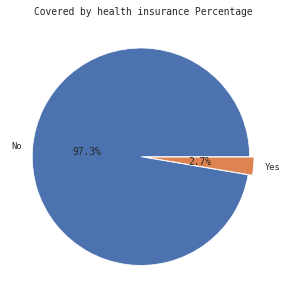

In [44]:
labels = perc.keys() # get labels from perc
# autopct allows formatting percentage string
plt.pie(x=perc, autopct="%.1f%%", explode=[0.02]*2, labels=labels, pctdistance=0.5)
plt.title("Covered by health insurance Percentage")
plt.savefig('insurance_pie_chart.png');

Countplot for target variable. Countplot shows the number of each category.

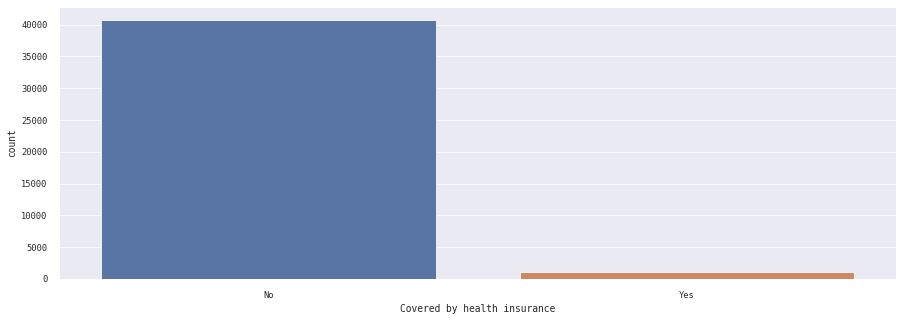

In [45]:
sns.countplot(x='Covered by health insurance', data=target)
plt.savefig('insurance_count_plot.png'); 

**Observation:** The pie plot and count plot shows that there is high imbalance in the target variable. About $97.3\%$ of the populace are without health insurance coverage, while $2.7\%$ have health insurance coverage.

### Means of Accessing Health Insurance

Among those that answered yes to having a health insurance coverage, what type of health insurance do they have?

Get different types of insurance coverage from df1

In [46]:
insurance = []
for col in data.columns:
  if 'Health insurance type:' in col:
   insurance.append(col)
print(insurance)

['Health insurance type: mutual/community organization', 'Health insurance type: provided by employer', 'Health insurance type: social security', 'Health insurance type: private/commercially purchased', 'Health insurance type: other']


Get dictionary with insurance type name as key and number of people having the insurance as value.

In [47]:
keys = []
values = []
for i in insurance:
  # get names of different insurance types
  keys.append(data[i].value_counts().name) 
  # get number of people that answered yes to having a particular insurance type
  values.append(data[i].value_counts()['Yes'])
  # create the dict
  insurance_type = {key: value for key,value in 
                    zip(keys,values)
                    }
pprint(insurance_type)

{'Health insurance type: mutual/community organization': 210,
 'Health insurance type: other': 15,
 'Health insurance type: private/commercially purchased': 91,
 'Health insurance type: provided by employer': 794,
 'Health insurance type: social security': 17}


Convert insurance_type dict to a dataframe, with keys as a column and count as another column.

In [48]:
insurance_df = pd.DataFrame(list(insurance_type.items()), 
                            columns=['insurance type','count'])
insurance_df

,insurance type,count
0,Health insurance type: mutual/community organi...,210
1,Health insurance type: provided by employer,794
2,Health insurance type: social security,17
3,Health insurance type: private/commercially pu...,91
4,Health insurance type: other,15


Rename insurance type column using only the type of insurance.

In [49]:
insurance_df['insurance type'] = [item.split(': ')[-1] for item in insurance_df['insurance type']]
insurance_df

,insurance type,count
0,mutual/community organization,210
1,provided by employer,794
2,social security,17
3,private/commercially purchased,91
4,other,15


Plot class count for insurance types

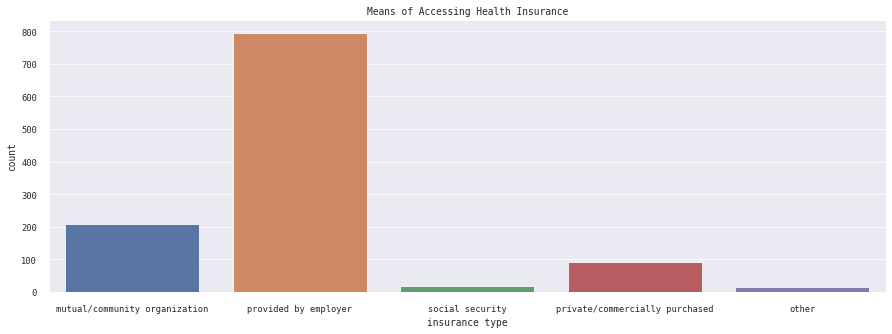

In [50]:
ax = sns.barplot('insurance type', 'count', data=insurance_df)
plt.title('Means of Accessing Health Insurance')
plt.savefig('insurance_type_plot.png');

**Observation:** Most insurance are provided by the employer. Very few people are insured via social security. In addition, those who have privately acquired health insurance are 91 in number. 
 
Health insurance companies might have a better chance of getting people to take up their policies through strengthened engagement with employers. Employer-provided policies are ~8 times more common than privately-acquired policies.

### Numerical features EDA

Get columns for numerical and categorical features from dataframe

In [51]:
cat_feat = data.select_dtypes(exclude = np.number).columns
num_feat = data.select_dtypes(exclude = object).columns

In [52]:
print(num_feat)

Index(['Number of children 5 and under in household (de jure)',
       'Wealth index factor score for urban/rural (5 decimals)',
       'Age of respondent at 1st birth', 'Age at first cohabitation'],
      dtype='object')


In [53]:
len(num_feat)

4

Distribution plot and box plot for numeric features in the dataframe 

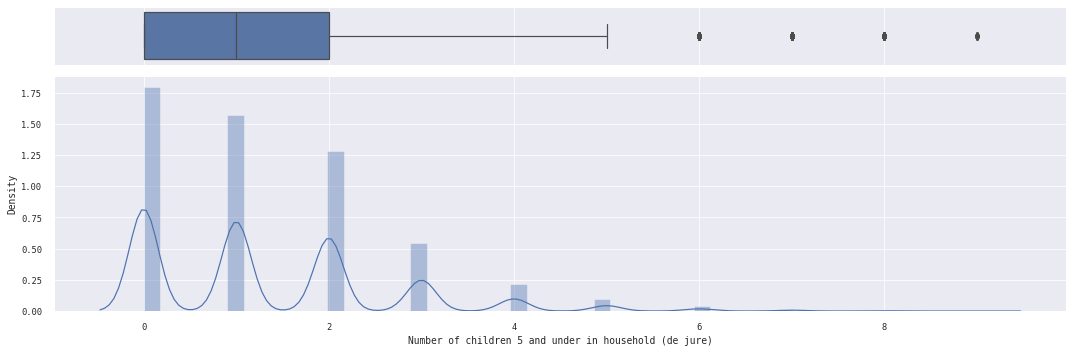

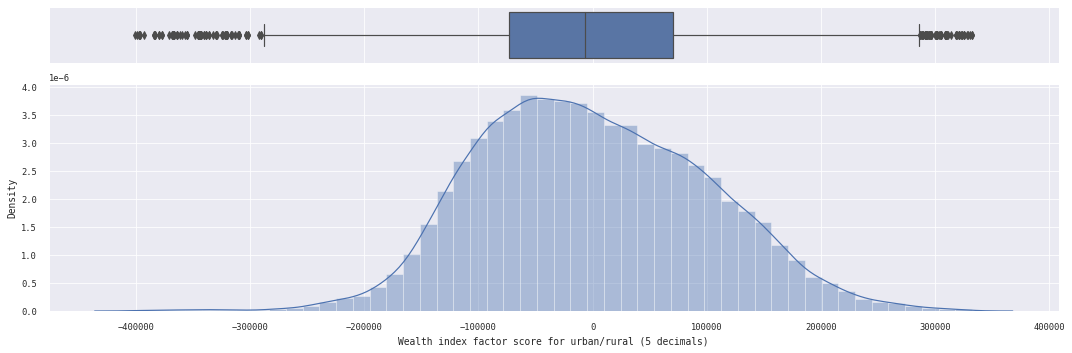

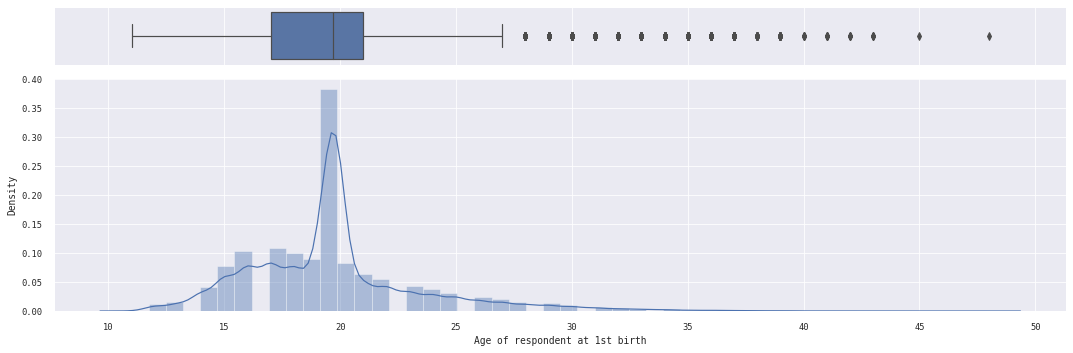

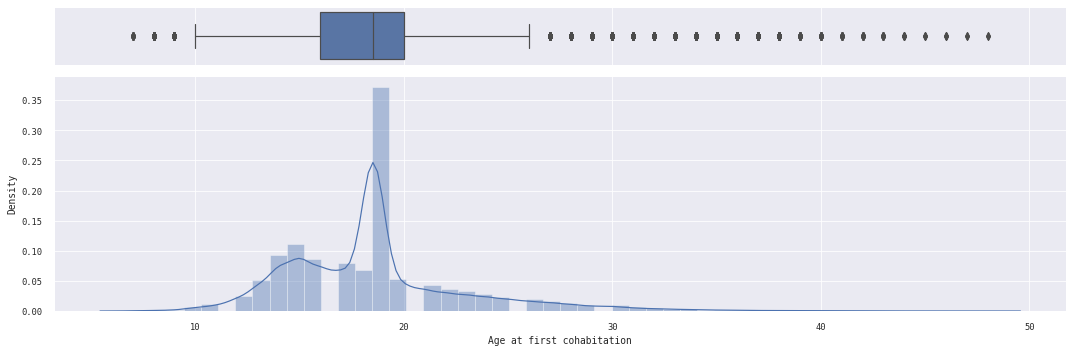

In [54]:
for col in data[num_feat]:
    # set 2 subplots and set ratio of plots 
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.20, .80)
                                        })   
    g1 = sns.boxplot(col, ax=ax_box, data=data) # boxplot
    g1.set(xlabel=None) # remove x axis label for boxplot
    g2 = sns.distplot(data[col], ax=ax_hist) # distribution plot 
    plt.tight_layout()
    plt.show()

**Observation:** 

### Categorical features EDA

Countplot for categorical features in the dataframe 

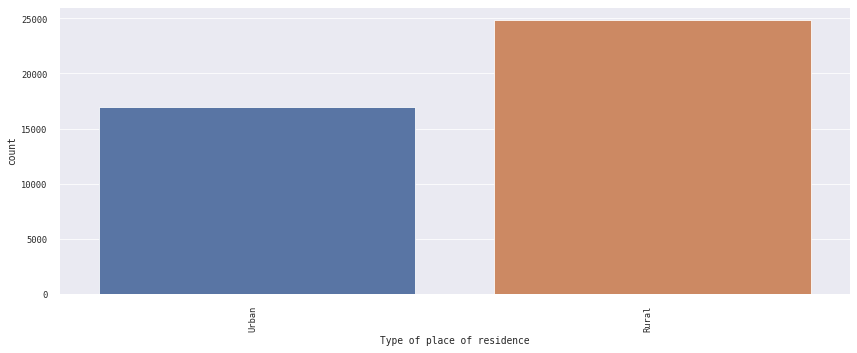

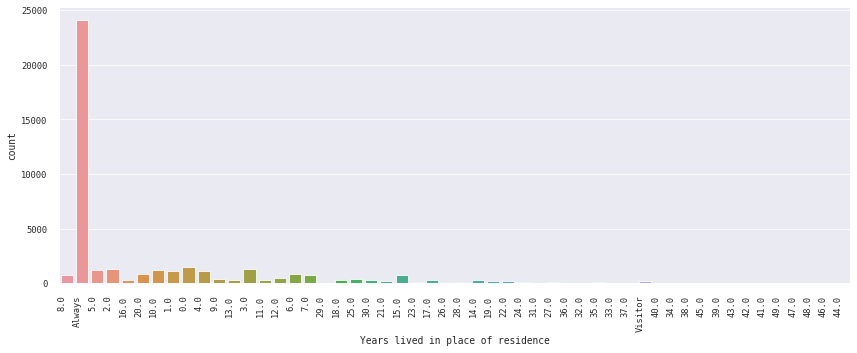

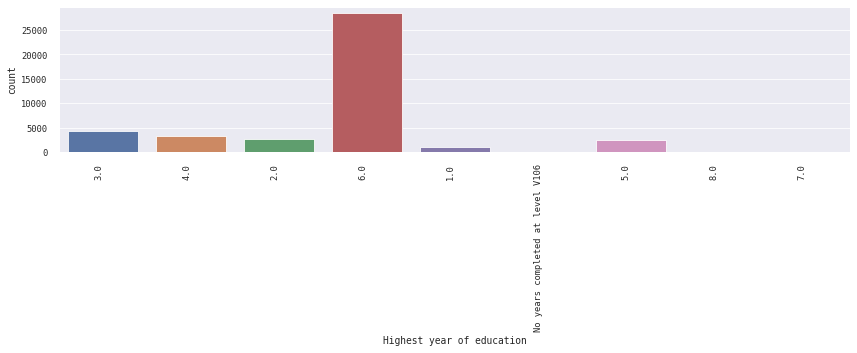

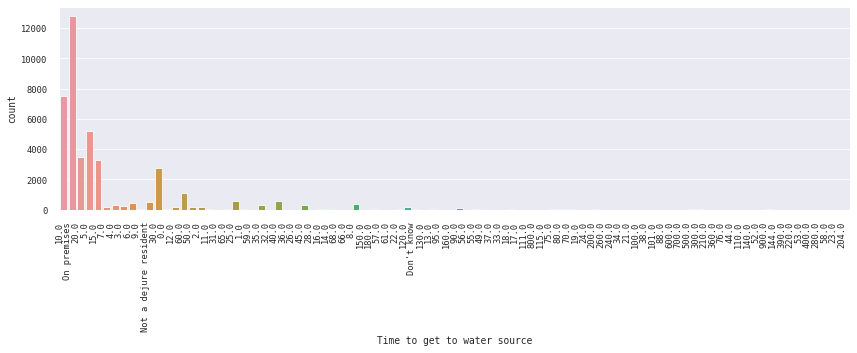

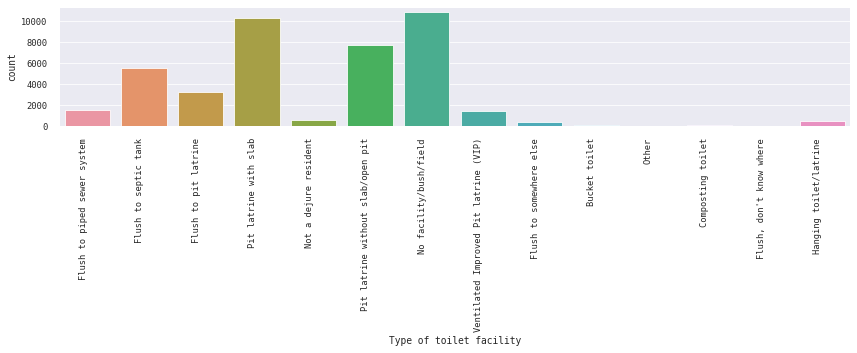

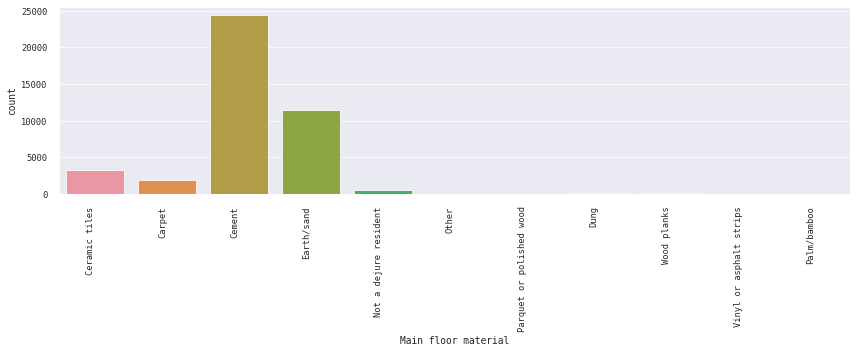

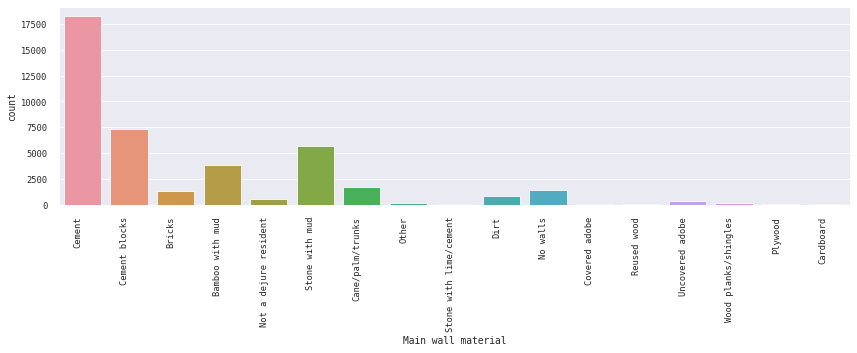

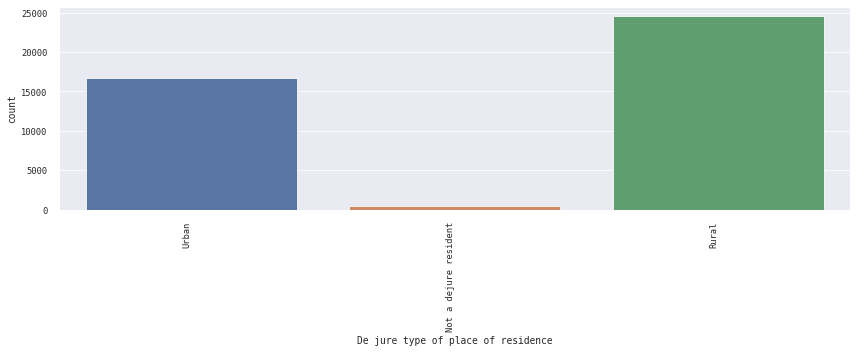

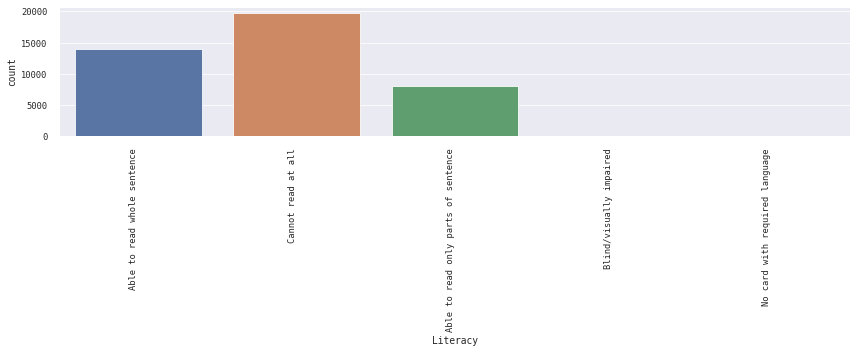

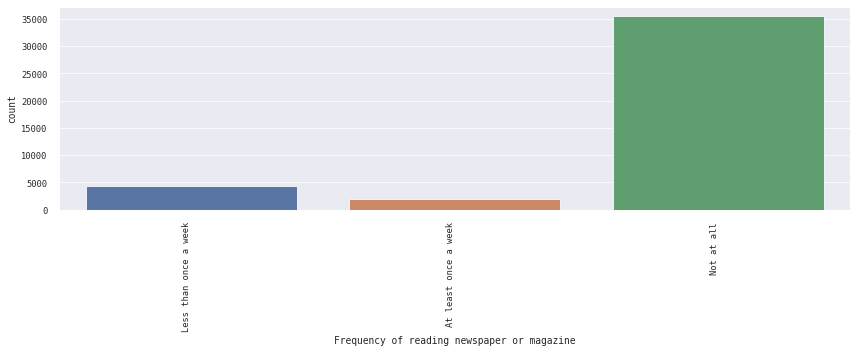

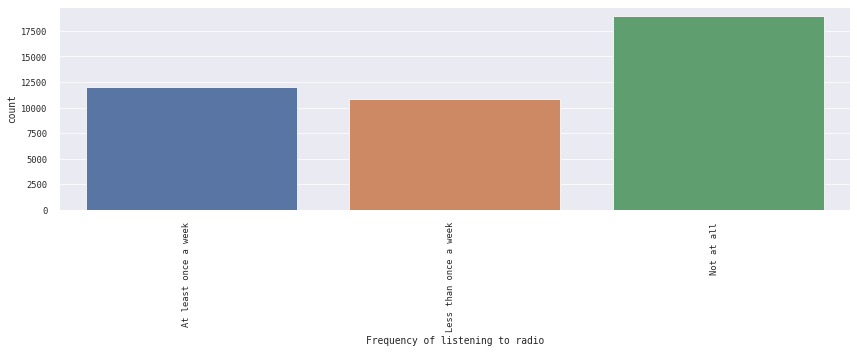

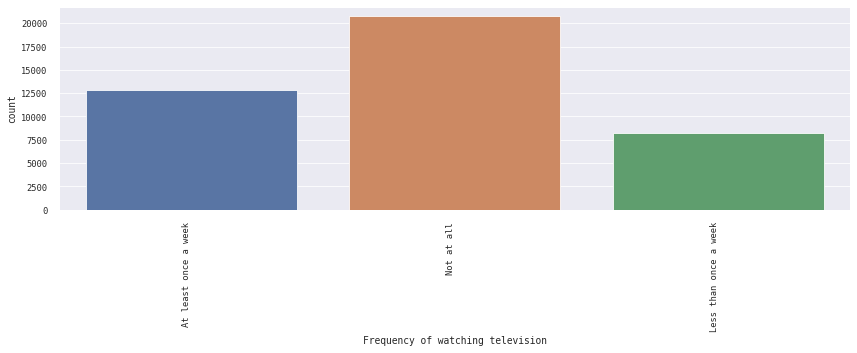

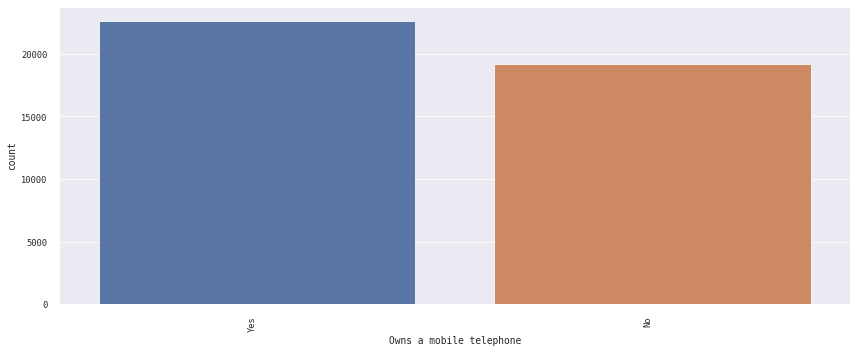

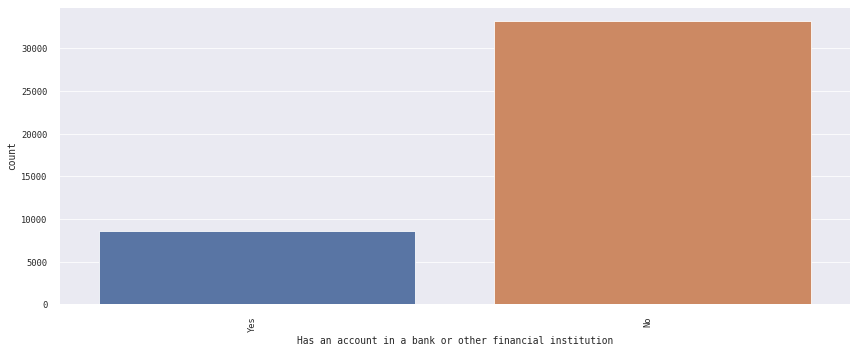

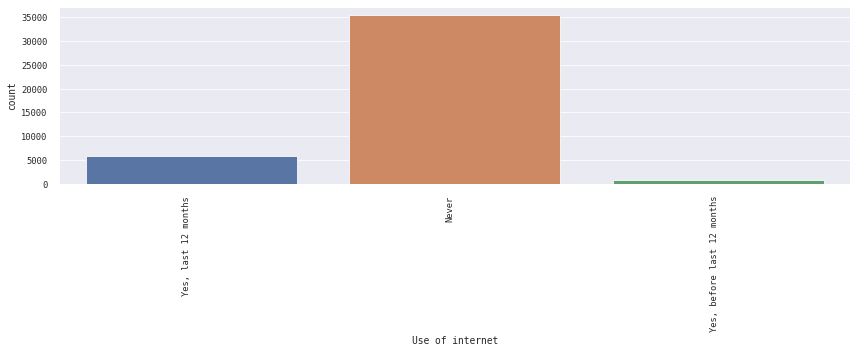

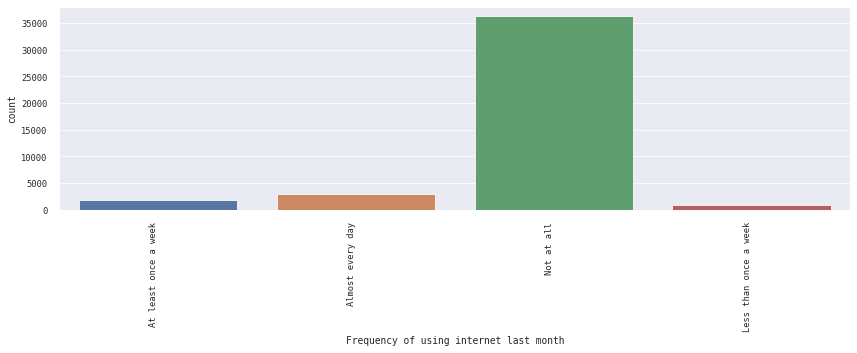

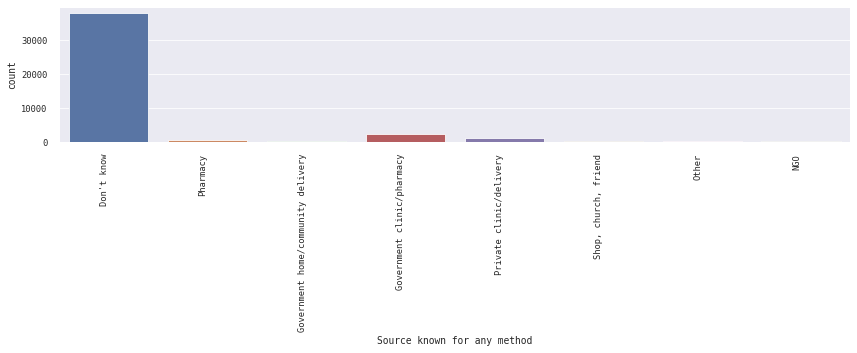

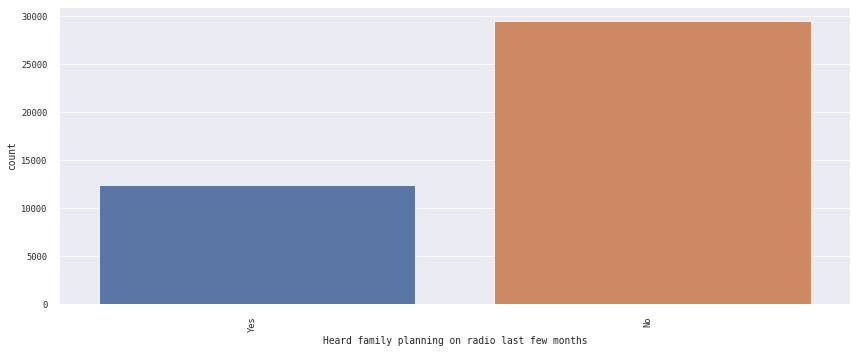

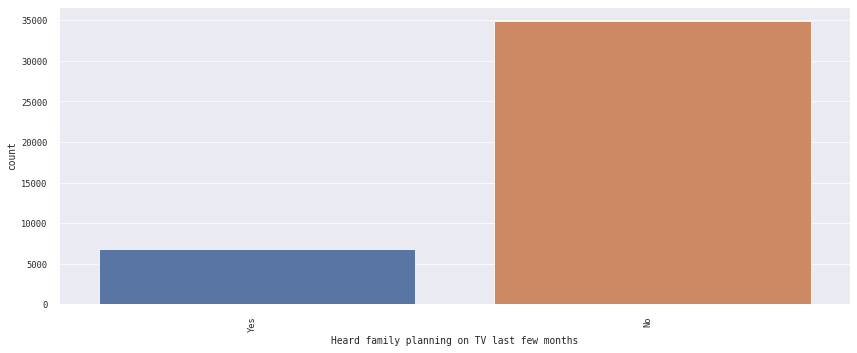

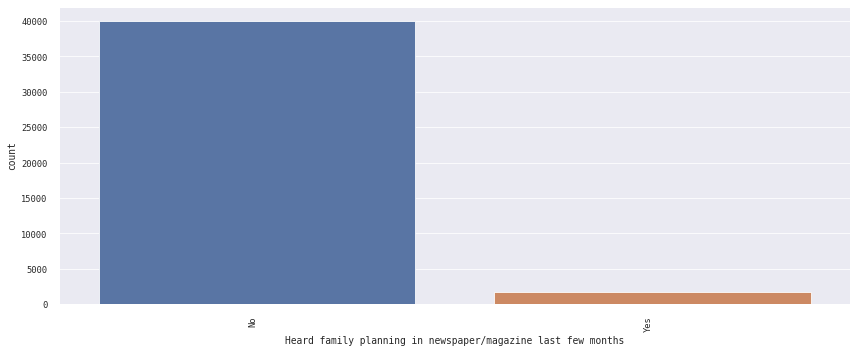

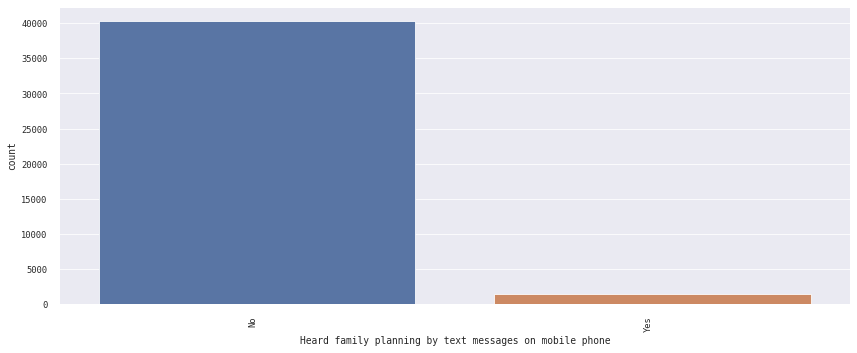

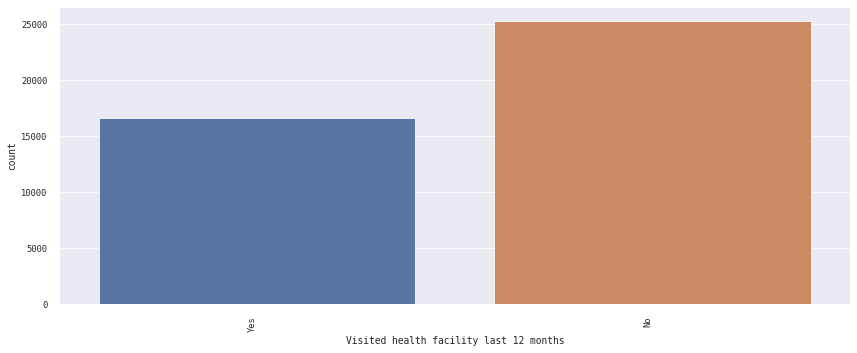

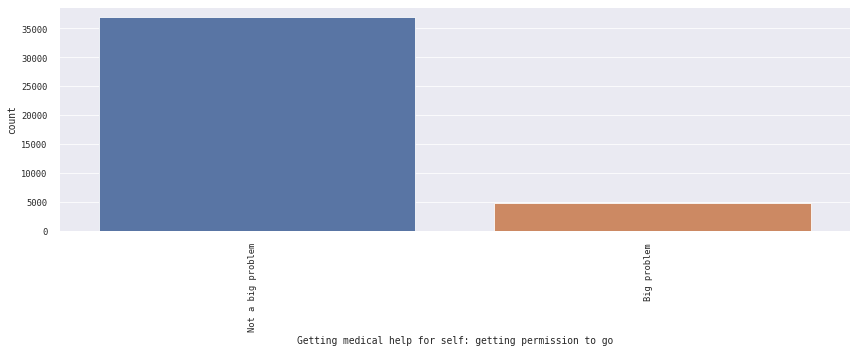

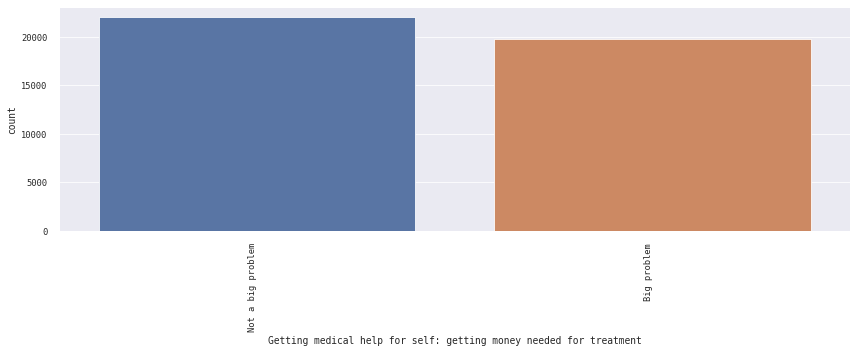

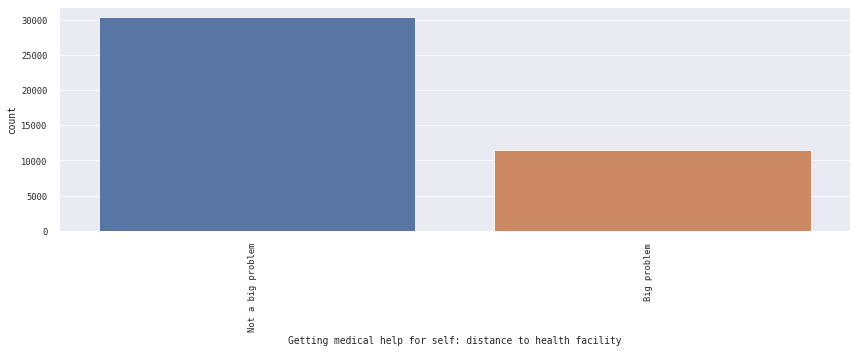

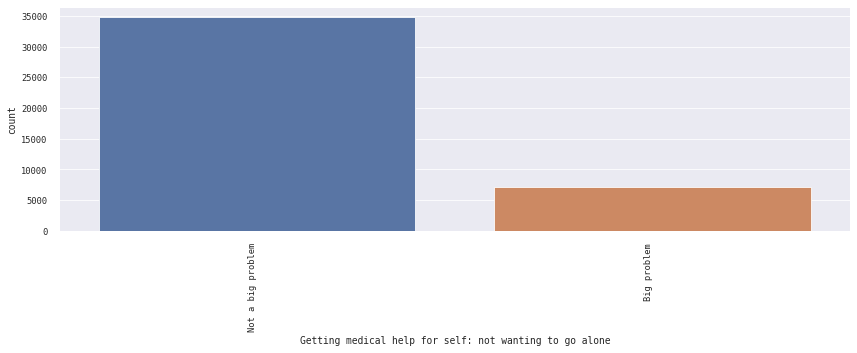

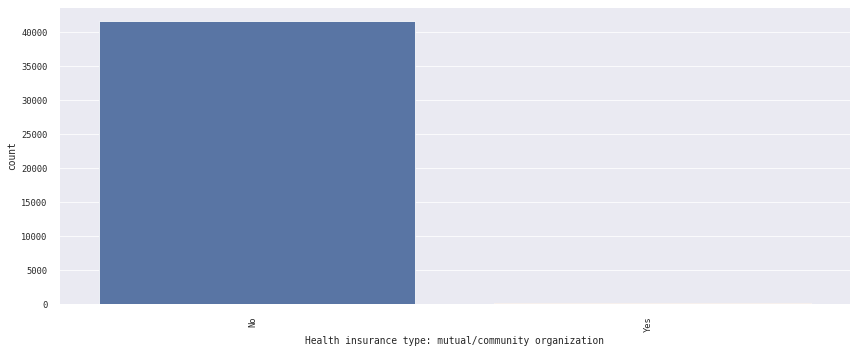

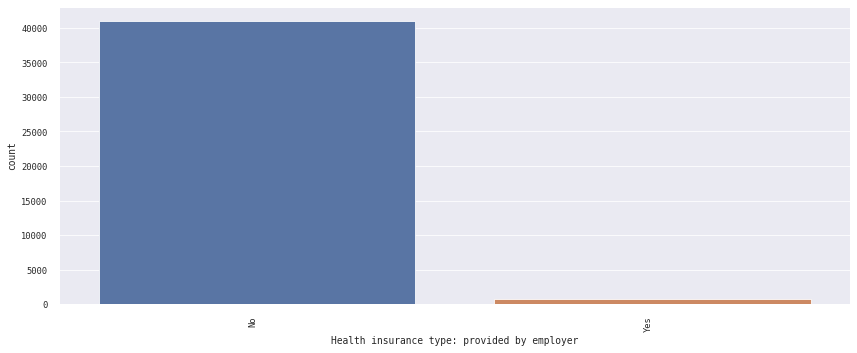

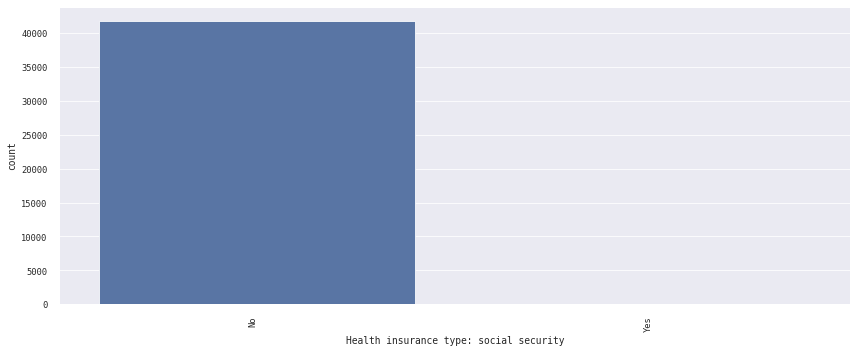

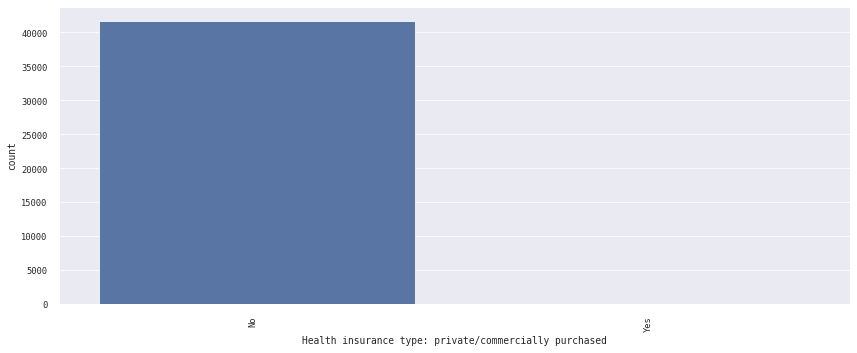

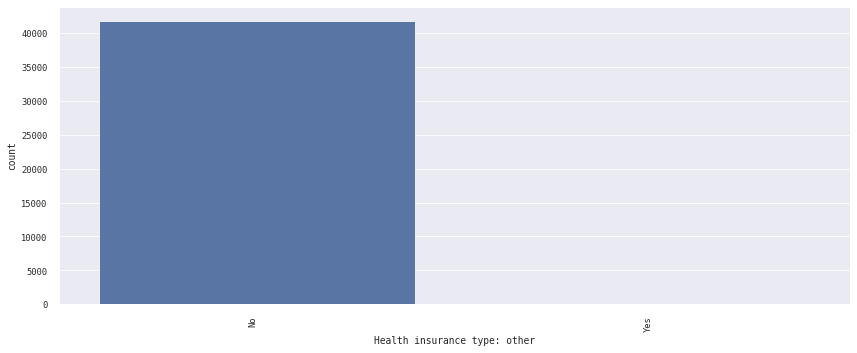

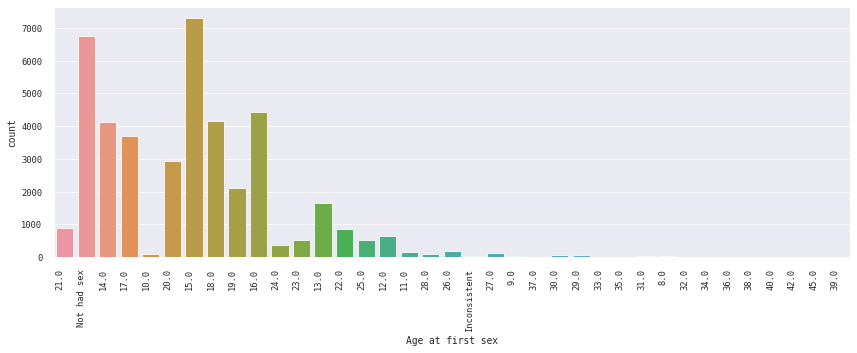

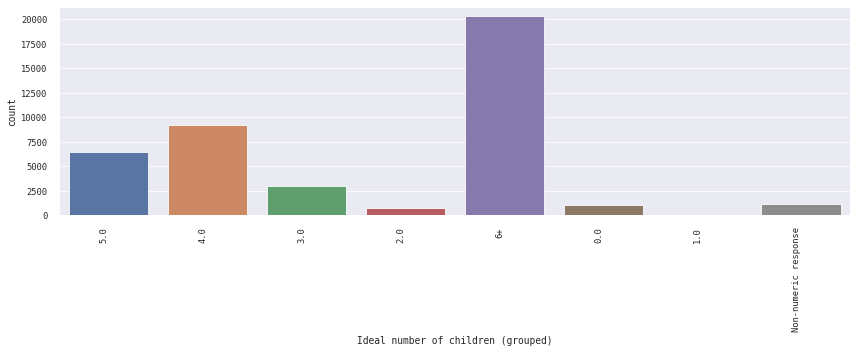

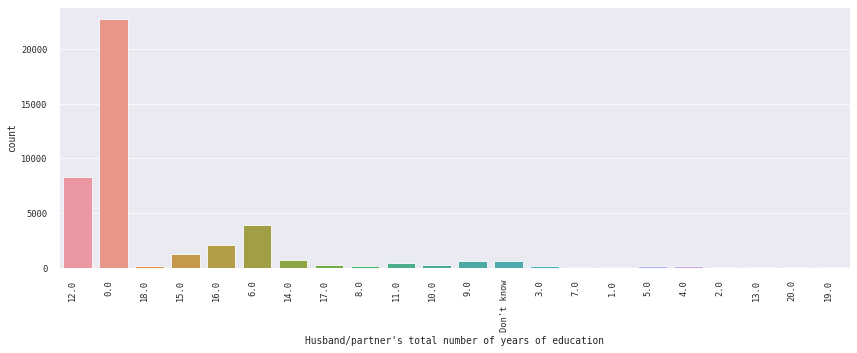

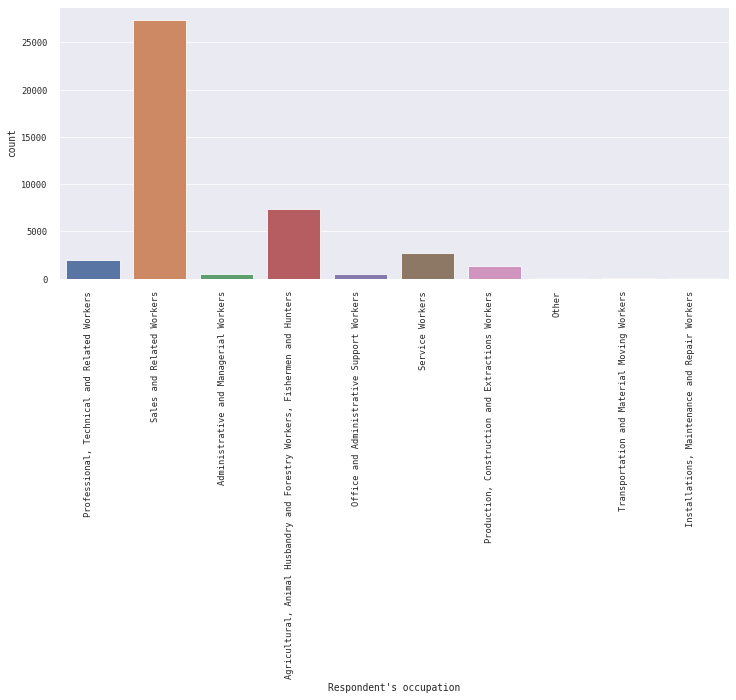

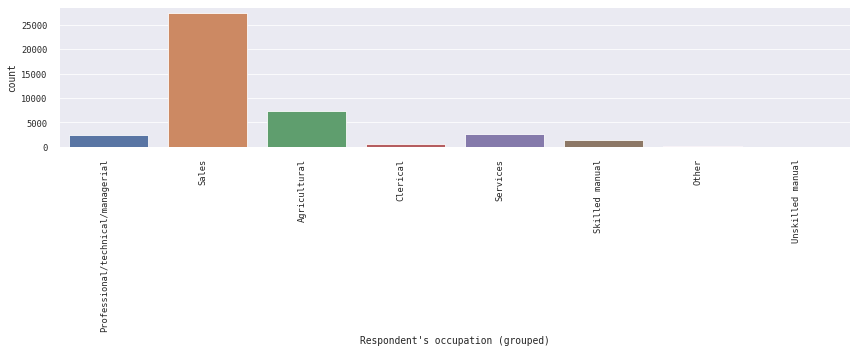

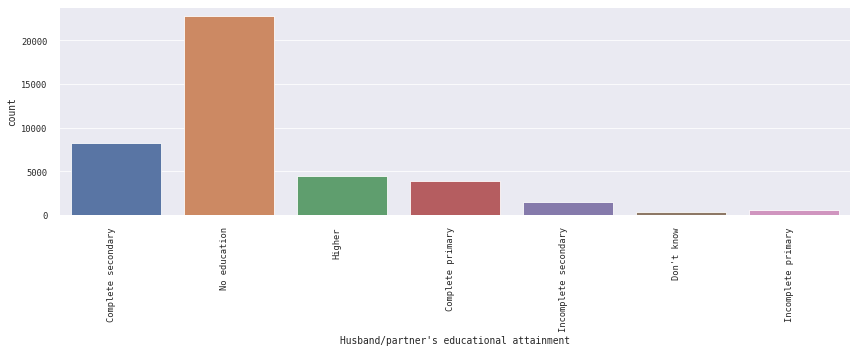

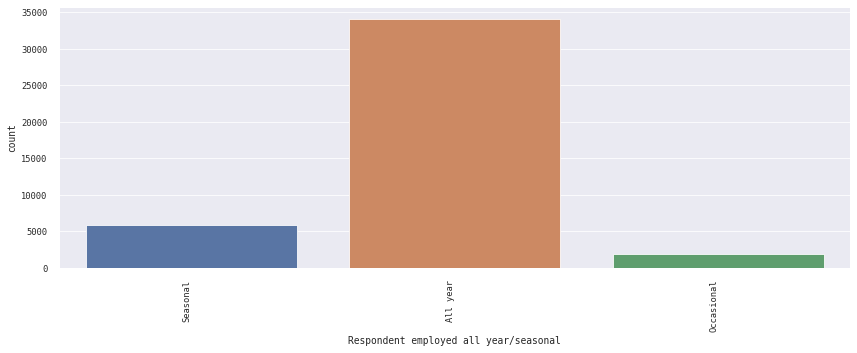

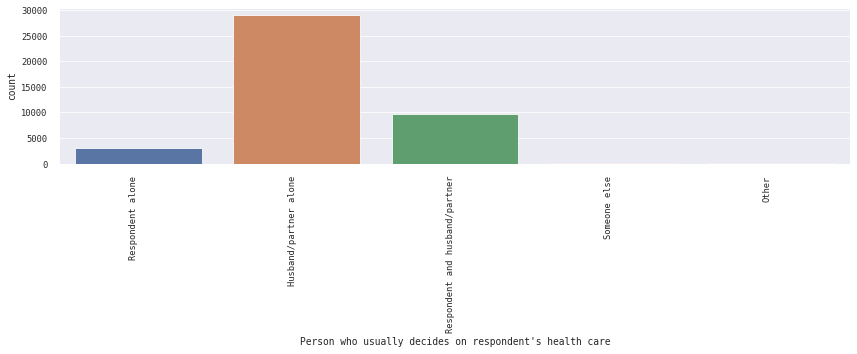

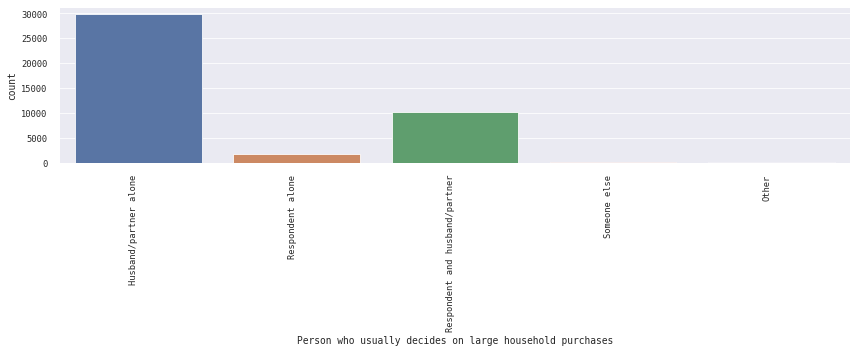

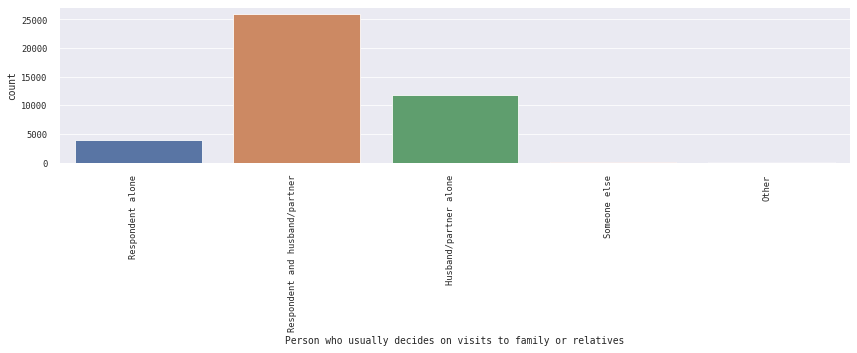

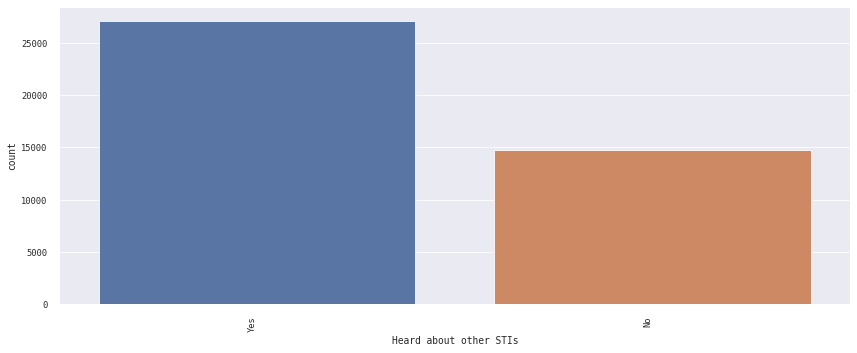

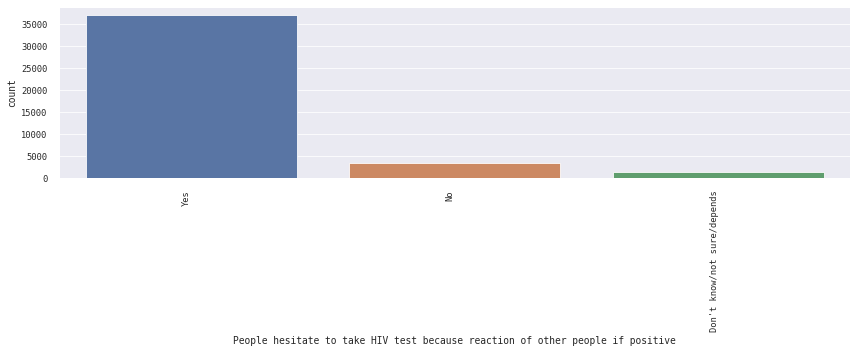

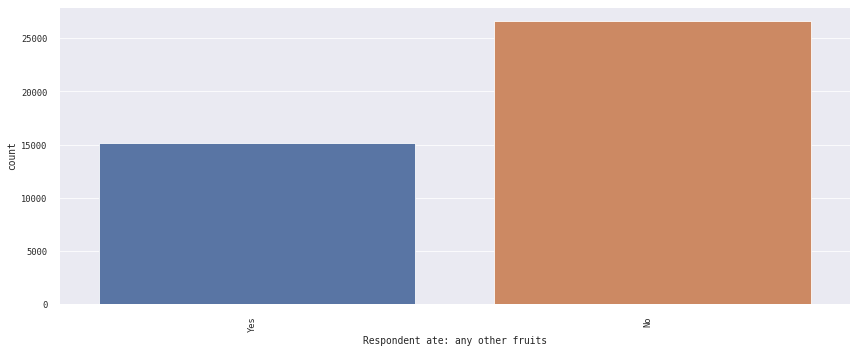

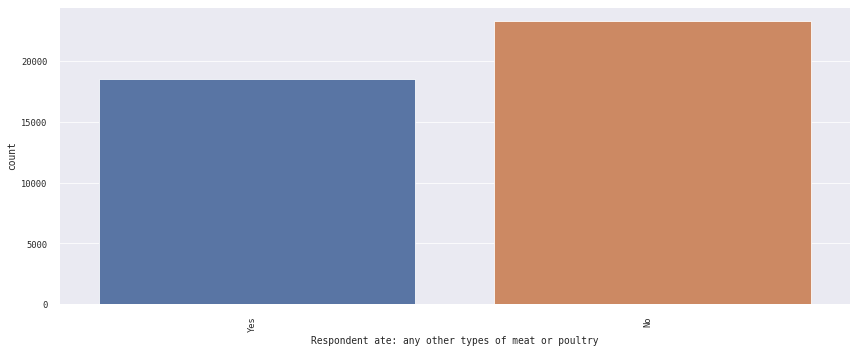

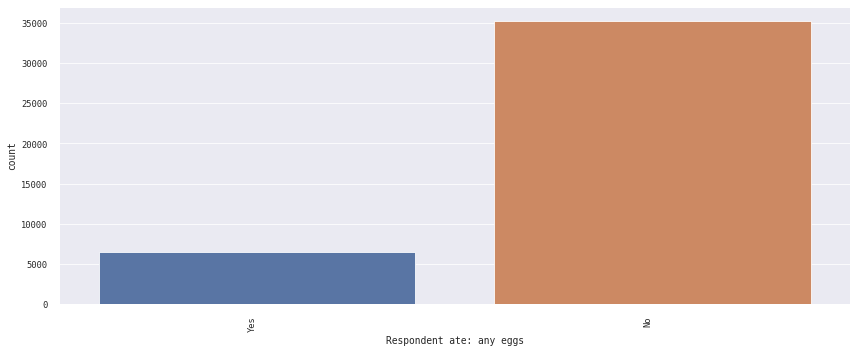

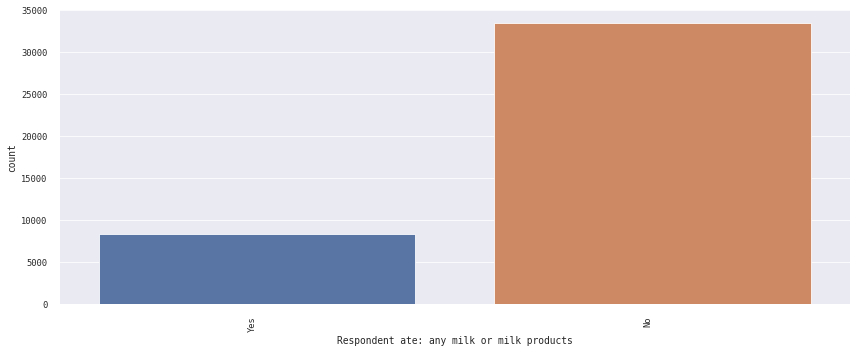

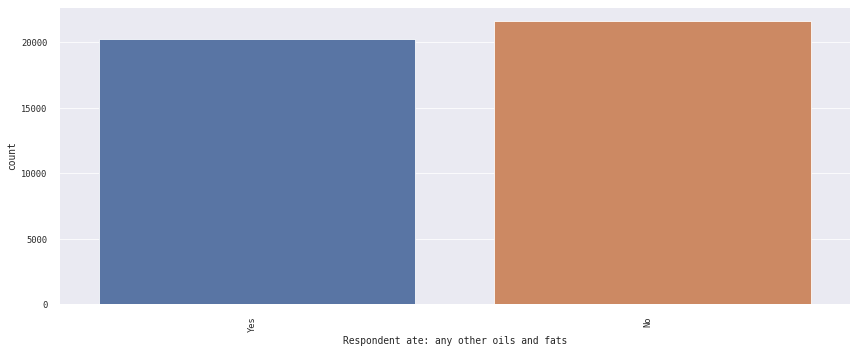

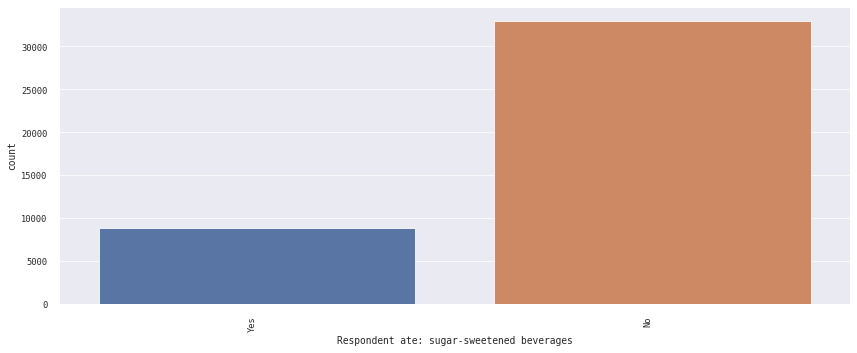

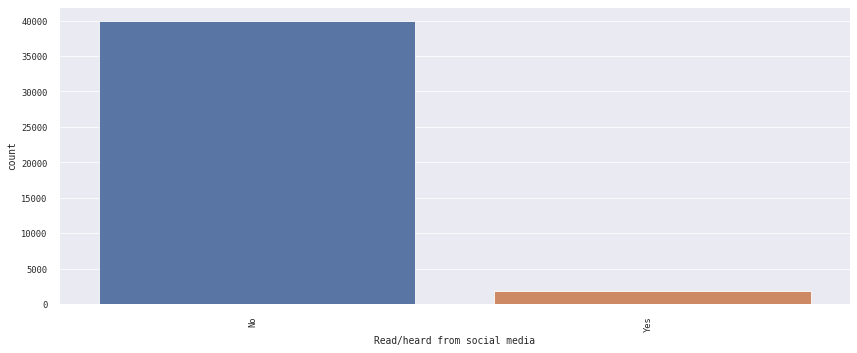

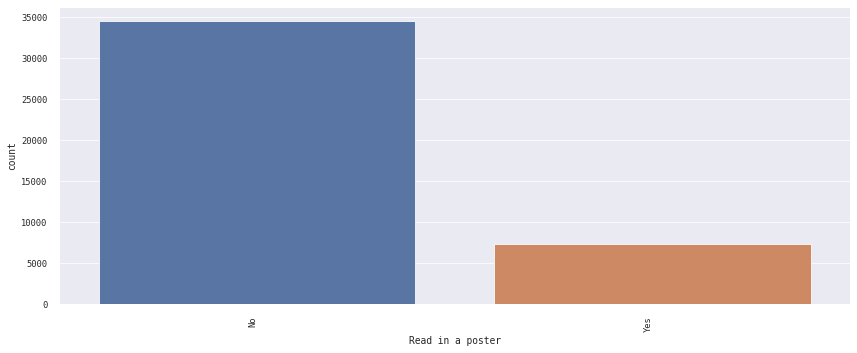

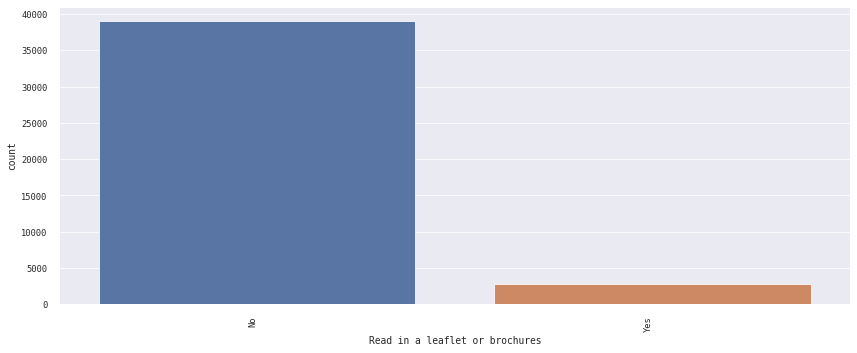

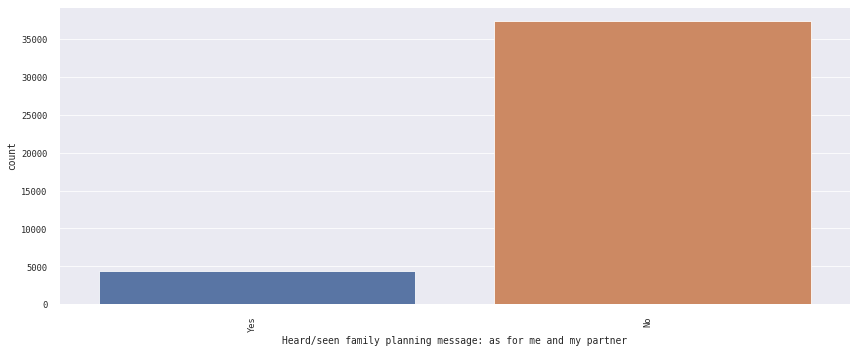

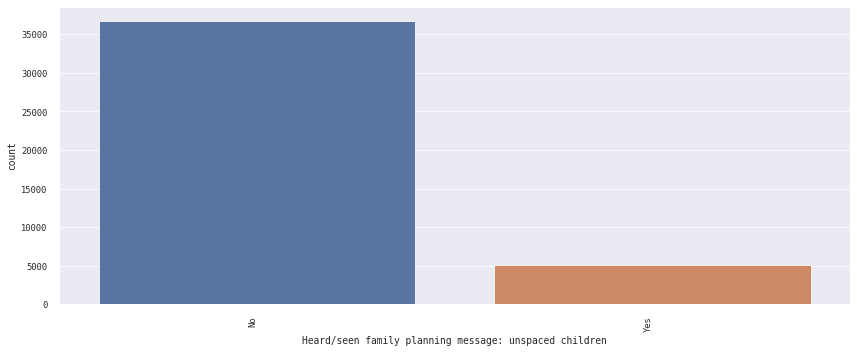

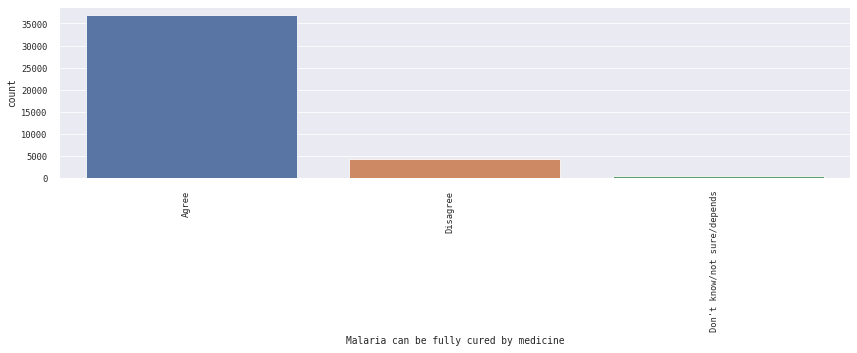

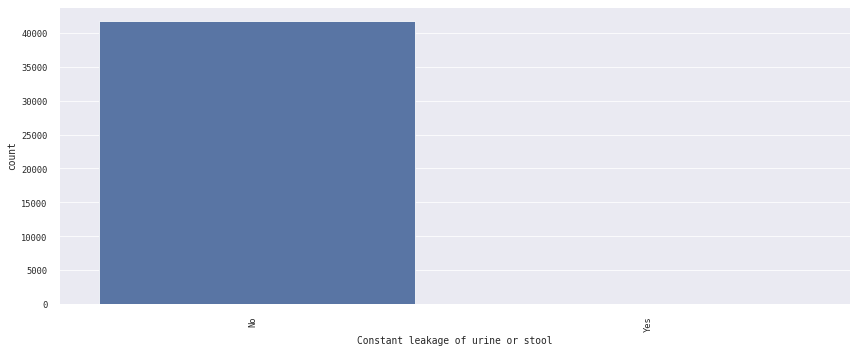

In [55]:
object_count_plot(data)

## Extra data cleaning

Drop the types of insurance package (insurance list) from data

In [56]:
data.drop(insurance, axis=1, inplace=True)
data.shape 

(41821, 55)

## Build Model and Evaluate 

Concatenate target variable to data

In [57]:
data['target'] = target
data.head()  

,Type of place of residence,Years lived in place of residence,Highest year of education,Time to get to water source,Type of toilet facility,Main floor material,Main wall material,Number of children 5 and under in household (de jure),De jure type of place of residence,Literacy,Frequency of reading newspaper or magazine,Frequency of listening to radio,Frequency of watching television,Owns a mobile telephone,Has an account in a bank or other financial institution,Use of internet,Frequency of using internet last month,Wealth index factor score for urban/rural (5 decimals),Age of respondent at 1st birth,Source known for any method,Heard family planning on radio last few months,Heard family planning on TV last few months,Heard family planning in newspaper/magazine last few months,Heard family planning by text messages on mobile phone,Visited health facility last 12 months,Getting medical help for self: getting permission to go,Getting medical help for self: getting money needed for treatment,Getting medical help for self: distance to health facility,Getting medical help for self: not wanting to go alone,Age at first cohabitation,Age at first sex,Ideal number of children (grouped),Husband/partner's total number of years of education,Respondent's occupation,Respondent's occupation (grouped),Husband/partner's educational attainment,Respondent employed all year/seasonal,Person who usually decides on respondent's health care,Person who usually decides on large household purchases,Person who usually decides on visits to family or relatives,Heard about other STIs,People hesitate to take HIV test because reaction of other people if positive,Respondent ate: any other fruits,Respondent ate: any other types of meat or poultry,Respondent ate: any eggs,Respondent ate: any milk or milk products,Respondent ate: any other oils and fats,Respondent ate: sugar-sweetened beverages,Read/heard from social media,Read in a poster,Read in a leaflet or brochures,Heard/seen family planning message: as for me and my partner,Heard/seen family planning message: unspaced children,Malaria can be fully cured by medicine,Constant leakage of urine or stool,target
0,Urban,8,3,10,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Less than once a week,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",At least once a week,115856.0,22.000000,Don't know,Yes,Yes,No,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,21.000000,21,5,12,"Professional, Technical and Related Workers",Professional/technical/managerial,Complete secondary,Seasonal,Respondent alone,Husband/partner alone,Respondent alone,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,No,Agree,No,No
1,Urban,Always,4,On premises,Flush to septic tank,Ceramic tiles,Cement blocks,0.0,Urban,Able to read whole sentence,At least once a week,Less than once a week,At least once a week,No,No,"Yes, last 12 months",Almost every day,149135.0,19.691784,Don't know,No,Yes,Yes,No,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,18.531394,Not had sex,4,0,Sales and Related Workers,Sales,No education,All year,Husband/partner alone,Husband/partner alone,Respondent and husband/partner,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes,No,No,No,No,Agree,No,No
2,Urban,5,3,20,Flush to piped sewer system,Carpet,Cement,2.0,Urban,Able to read whole sentence,Not at all,At least once a week,At least once a week,Yes,Yes,Never,Not at all,130865.0,28.000000,Don't know,Yes,Yes,No,Yes,Yes,Not a big problem,Not a big problem,Not a big problem,Not a big problem,28.000000,14,4,18,Sales and Related Workers,Sales,Higher,All year,Husband/partner alone,Husband/partner alone,Respondent and husband/partner,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,No,Agree,No,No
3,Urban,2,2,On premises,Flush to piped sewer system,Ceramic tiles,Cement,1.0,Urban,Able to read whole sentence,Not at all,At least once a week,At least once a week,Yes,Yes,"Yes, last 12 months",Less than once a

In [58]:
# data.to_csv('data_clean.csv', index = False)

Make a copy of data and drop target column

In [59]:
df = data.copy()
df.drop('target', axis=1, inplace=True)
print(df.shape)

(41821, 55)


Get df columns that are categorical features.

In [60]:
cat_feat = df.select_dtypes(exclude = np.number).columns 
cat_feat

Index(['Type of place of residence', 'Years lived in place of residence',
       'Highest year of education', 'Time to get to water source',
       'Type of toilet facility', 'Main floor material', 'Main wall material',
       'De jure type of place of residence', 'Literacy',
       'Frequency of reading newspaper or magazine',
       'Frequency of listening to radio', 'Frequency of watching television',
       'Owns a mobile telephone',
       'Has an account in a bank or other financial institution',
       'Use of internet', 'Frequency of using internet last month',
       'Source known for any method',
       'Heard family planning on radio last few months',
       'Heard family planning on TV last few months',
       'Heard family planning in newspaper/magazine last few months',
       'Heard family planning by text messages on mobile phone',
       'Visited health facility last 12 months',
       'Getting medical help for self: getting permission to go',
       'Getting medical h

One hot encode categorical variables in df

In [61]:
for feat in cat_feat:
    dummy = pd.get_dummies(df[feat], prefix=feat)
    df = pd.concat([df,dummy], axis=1)
    del df[feat]
df.shape 

(41821, 397)

Label encode target column

In [62]:
target_mapper = {'No': 0, 'Yes': 1}
def target_encode(val):
    return target_mapper[val]

data['target'] = data['target'].apply(target_encode)

In [63]:
data['target'].unique()

array([0, 1])

Set feature and target variables from df and data. X is features, y is target variable.

In [64]:
X = df
y = data['target']
counter = Counter(y)

print(X.shape, y.shape) 
print('Target class distribution: {}'.format(
    {k: v for k, v in counter.items()}))

(41821, 397) (41821,)
Target class distribution: {0: 40704, 1: 1117}


We use StratifiedKFold to split the data, since we are dealing with a highly imbalaced dataset. StratifiedKFold splits a dataset randomly, although in such a way that maintains the same class distribution in each subset

In [65]:
from sklearn.model_selection import StratifiedKFold

# set number of splits
K = 10
# initiate StratifiedKFold 
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

### Helper functions

In [66]:
from sklearn.metrics import ( f1_score, classification_report, 
                             confusion_matrix, roc_auc_score )
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [67]:
# store results for result comparison
Model = []
Resample = []
F1score = []
AUCROC = [] 

In [68]:
def fit_predict(model, X, y, sampling):
    ''' Description: Train model specified on dataset using StratifiedKFold 
        Arguements: model - machine learning model to be trained 
                  X - training dataset
                  y - target column
                  sampling - sampling technique
        Returns average confusion matrix, classification report and model name
    ''' 
    # set initial scores
    scores = 0
    auc_scores = 0
    # set empty list to store predictions on test set 
    test_oofs = []
    # get model name
    model_name = type(model).__name__ 
    # set a zero matrix of shape (2,2) for confusion matrix
    matrix = np.zeros((2,2))
    # set up empty lists to extend true and predicted values
    originalclass = []
    predictedclass = []

    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # training 
        if model_name in ['LogisticRegression','RandomForestClassifier', 'DecisionTreeClassifier']:
          model.fit(X_train, y_train)
        else:
          model.fit(X_train, y_train, 
                    eval_set=[(X_test, y_test)],
                    use_best_model=True)       
        
        # predicting on test set
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:,1]
        # append y_test and pred list to original class and predicted class
        # lists respectively
        originalclass.extend(y_test)
        predictedclass.extend(pred) 
        # get F1-score and roc_auc_score
        score = f1_score(y_test, pred, average='macro')
        roc = roc_auc_score(y_test, prob)
        # take mean of scores
        scores += score/K
        auc_scores += roc/K
        test_oofs.append(pred)
        # sum confusion matrix of each fold to matrix
        matrix += confusion_matrix(y_test,pred)

        print('Fold {} F1-score: {}'.format(i+1, score))

    print()
    print('Avg F1 score: {:.4f} '.format(scores))
    # get classification report
    report = classification_report(originalclass, predictedclass)

    # append results for comaprison
    Model.append(model_name) # model name
    Resample.append(sampling) # sampling style
    F1score.append(scores) # f1-score
    AUCROC.append(auc_scores) # roc_auc_score
    return matrix, report, model

In [69]:
def importance_plot(model, X):
  ''' Description: Creates feature importance plot for a trained model
      Arguements: model - trained model on dataset
                  X - training dataset
  ''' 
  model_name = type(model).__name__ 
  if model_name in ['LogisticRegression','LinearRegression']:
    feat_imp = pd.DataFrame(sorted(zip(model.coef_[0],X.columns)), 
                          columns=['Value','Feature']) 
  else:
    feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), 
                          columns=['Value','Feature']) 
  plt.figure(figsize=(20,15))
  imp_data = feat_imp.sort_values(by="Value", ascending=False)
  sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
  plt.ylabel('Feature Importance Score')
  plt.title(model_name + ' Feature Importance')
  plt.show() 

In [70]:
def heat_map(model, matrix):
  ''' Description: Creates confusion matrix heatmap for a model
      Arguements: model - trained model
                  matrix - model confusion matrix
  ''' 
  sns.heatmap(matrix, annot=True, fmt='g')
  plt.title(type(model).__name__  + ' Confusion Matrix Heatmap')
  plt.show() 

### Logistic Regression

In [71]:
log_reg = LogisticRegression()

Train and evaluate LogisticRegression Model

In [72]:
log_matrix, log_report, log_model_1 = fit_predict(log_reg, X, y, 'actual') 

Fold 1 F1-score: 0.49315400460438624
Fold 2 F1-score: 0.4932751726644856
Fold 3 F1-score: 0.4932751726644856
Fold 4 F1-score: 0.4932137663596704
Fold 5 F1-score: 0.4932137663596704
Fold 6 F1-score: 0.4931523451702824
Fold 7 F1-score: 0.4932137663596704
Fold 8 F1-score: 0.5021231001230207
Fold 9 F1-score: 0.4932137663596704
Fold 10 F1-score: 0.5106632160947046

Avg F1 score: 0.4958 


Classification report

In [73]:
print(log_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     40704
           1       0.43      0.00      0.01      1117

    accuracy                           0.97     41821
   macro avg       0.70      0.50      0.50     41821
weighted avg       0.96      0.97      0.96     41821



Confusion matrix heatmap

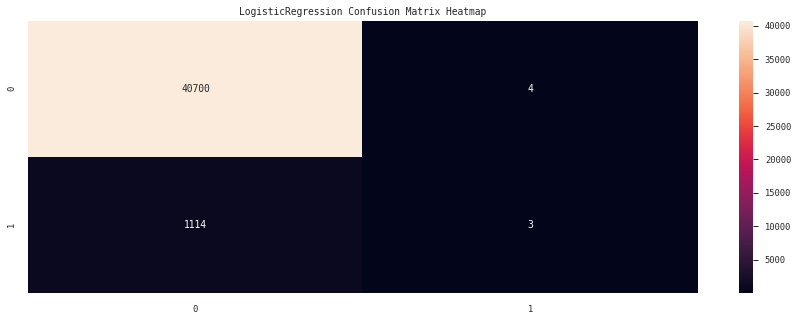

In [74]:
heat_map(log_model_1, log_matrix)

Feature Importance plot

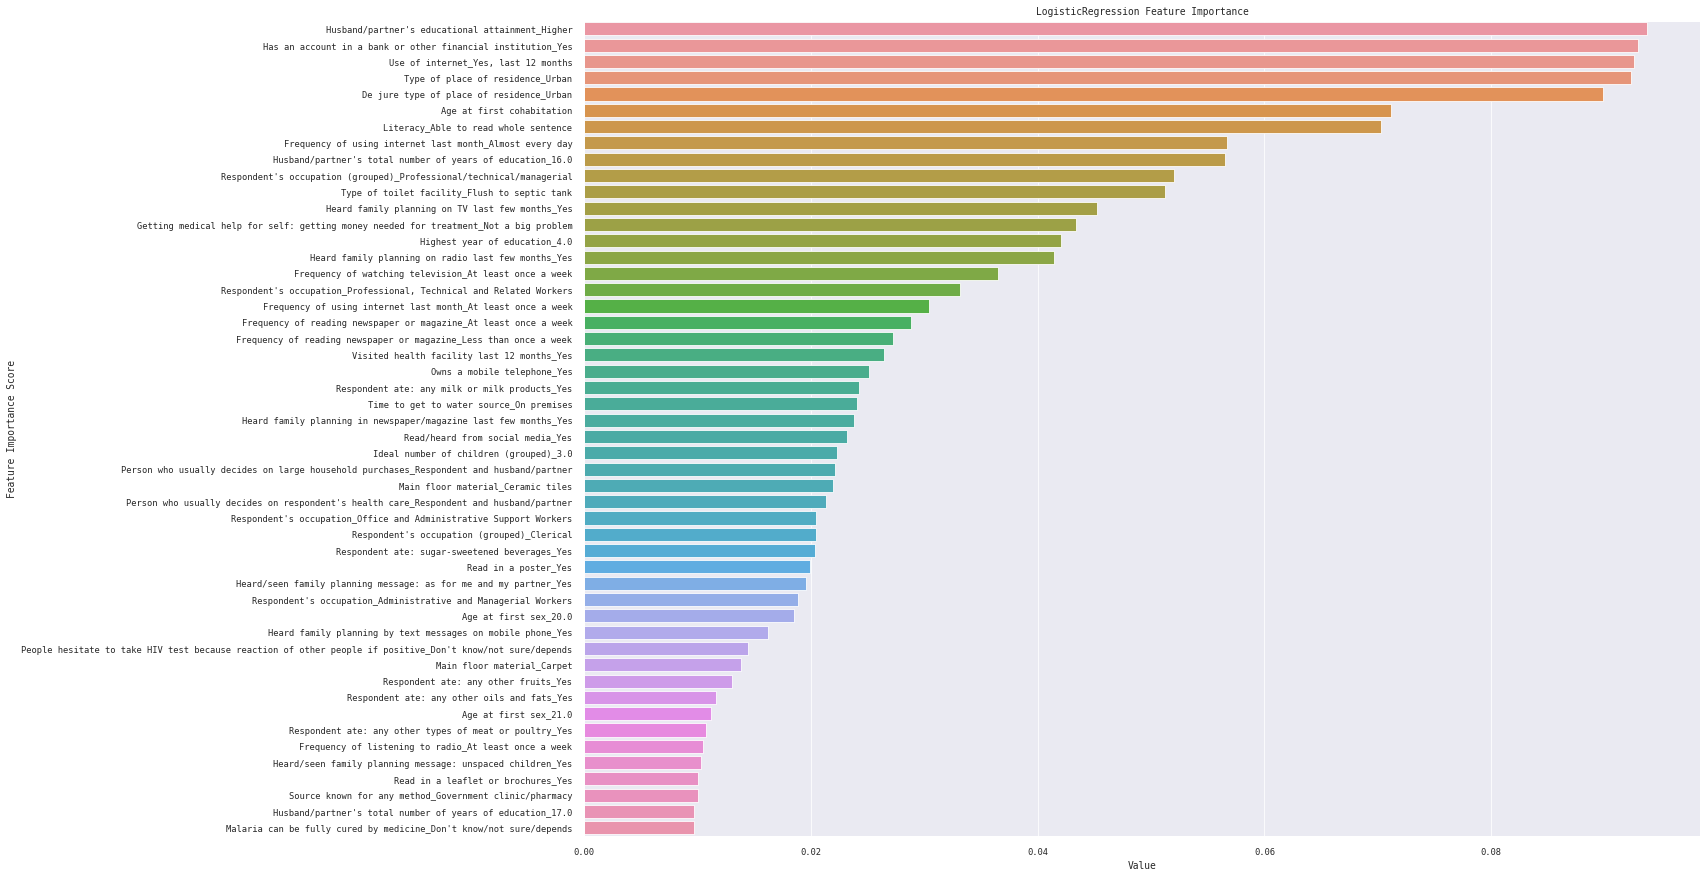

In [75]:
importance_plot(log_model_1, X)

### Random Forest Classifier

In [76]:
rf = RandomForestClassifier()

Train and evaluate RandomForest Model

In [77]:
rf_matrix, rf_report, rf_1 = fit_predict(rf, X, y, 'actual')

Fold 1 F1-score: 0.5279373040752351
Fold 2 F1-score: 0.5110938550757591
Fold 3 F1-score: 0.5194800950839891
Fold 4 F1-score: 0.5358242517173195
Fold 5 F1-score: 0.5191937857453426
Fold 6 F1-score: 0.5104518545770762
Fold 7 F1-score: 0.5362478352656599
Fold 8 F1-score: 0.5104518545770762
Fold 9 F1-score: 0.5362478352656599
Fold 10 F1-score: 0.5444200989077396

Avg F1 score: 0.5251 


Classification report

In [78]:
print(rf_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     40704
           1       0.82      0.03      0.06      1117

    accuracy                           0.97     41821
   macro avg       0.90      0.52      0.53     41821
weighted avg       0.97      0.97      0.96     41821



Confusion matrix heatmap

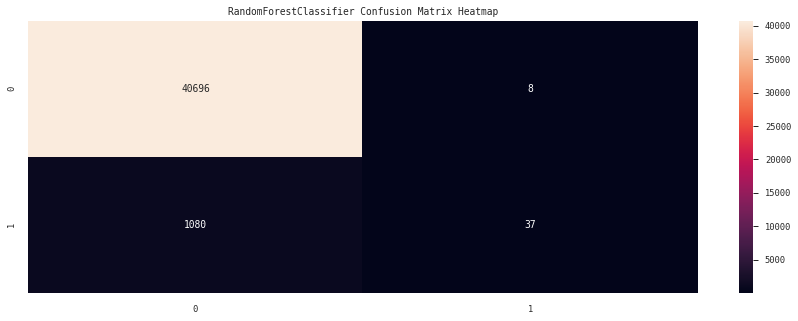

In [79]:
heat_map(rf_1, rf_matrix)

Feature Importance plot

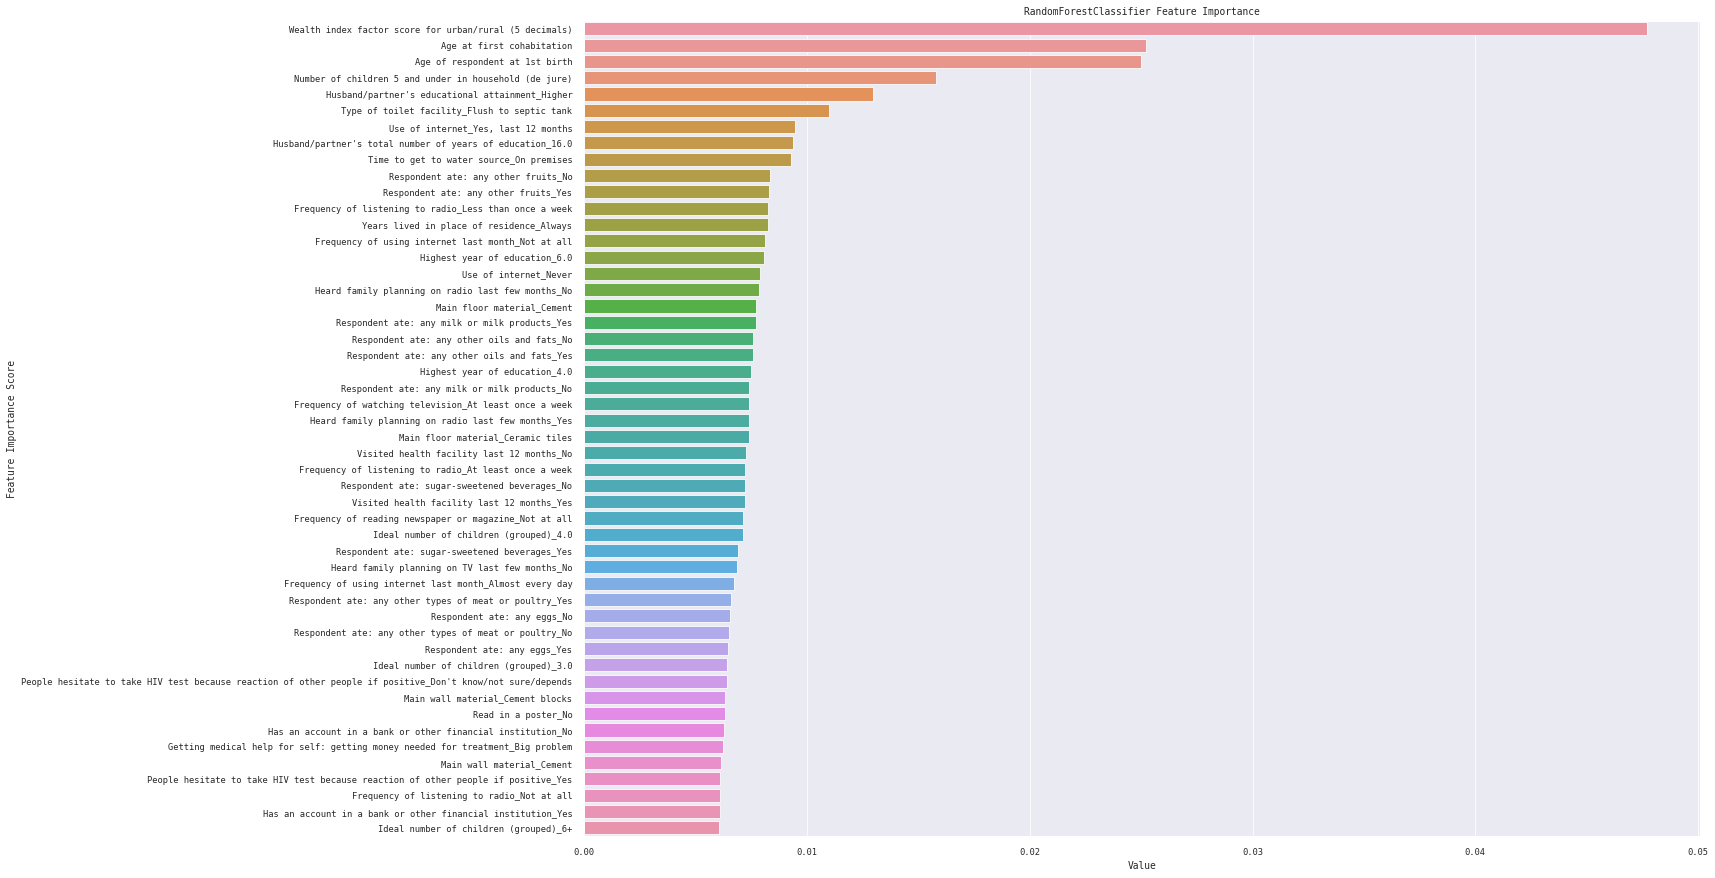

In [80]:
importance_plot(rf_1, X)

### Decision Tree Classifier 

In [81]:
dtree = DecisionTreeClassifier() 

Train and evaluate decision tree Model

In [82]:
dtree_matrix, dtree_report, dtree_1 = fit_predict(dtree, X, y, 'actual') 

Fold 1 F1-score: 0.6146862109015179
Fold 2 F1-score: 0.5962501845331349
Fold 3 F1-score: 0.585527427205788
Fold 4 F1-score: 0.5757430318635339
Fold 5 F1-score: 0.5643556167438354
Fold 6 F1-score: 0.5881681239087282
Fold 7 F1-score: 0.5846992482212017
Fold 8 F1-score: 0.5939687563715448
Fold 9 F1-score: 0.6165383288143949
Fold 10 F1-score: 0.5744810744810744

Avg F1 score: 0.5894 


Classification report

In [83]:
print(dtree_report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     40704
           1       0.19      0.22      0.20      1117

    accuracy                           0.95     41821
   macro avg       0.58      0.60      0.59     41821
weighted avg       0.96      0.95      0.96     41821



Confusion matrix heatmap

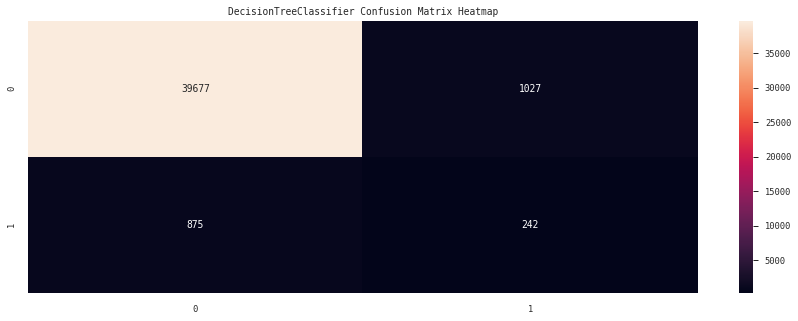

In [84]:
heat_map(dtree_1, dtree_matrix)

Feature Importance plot

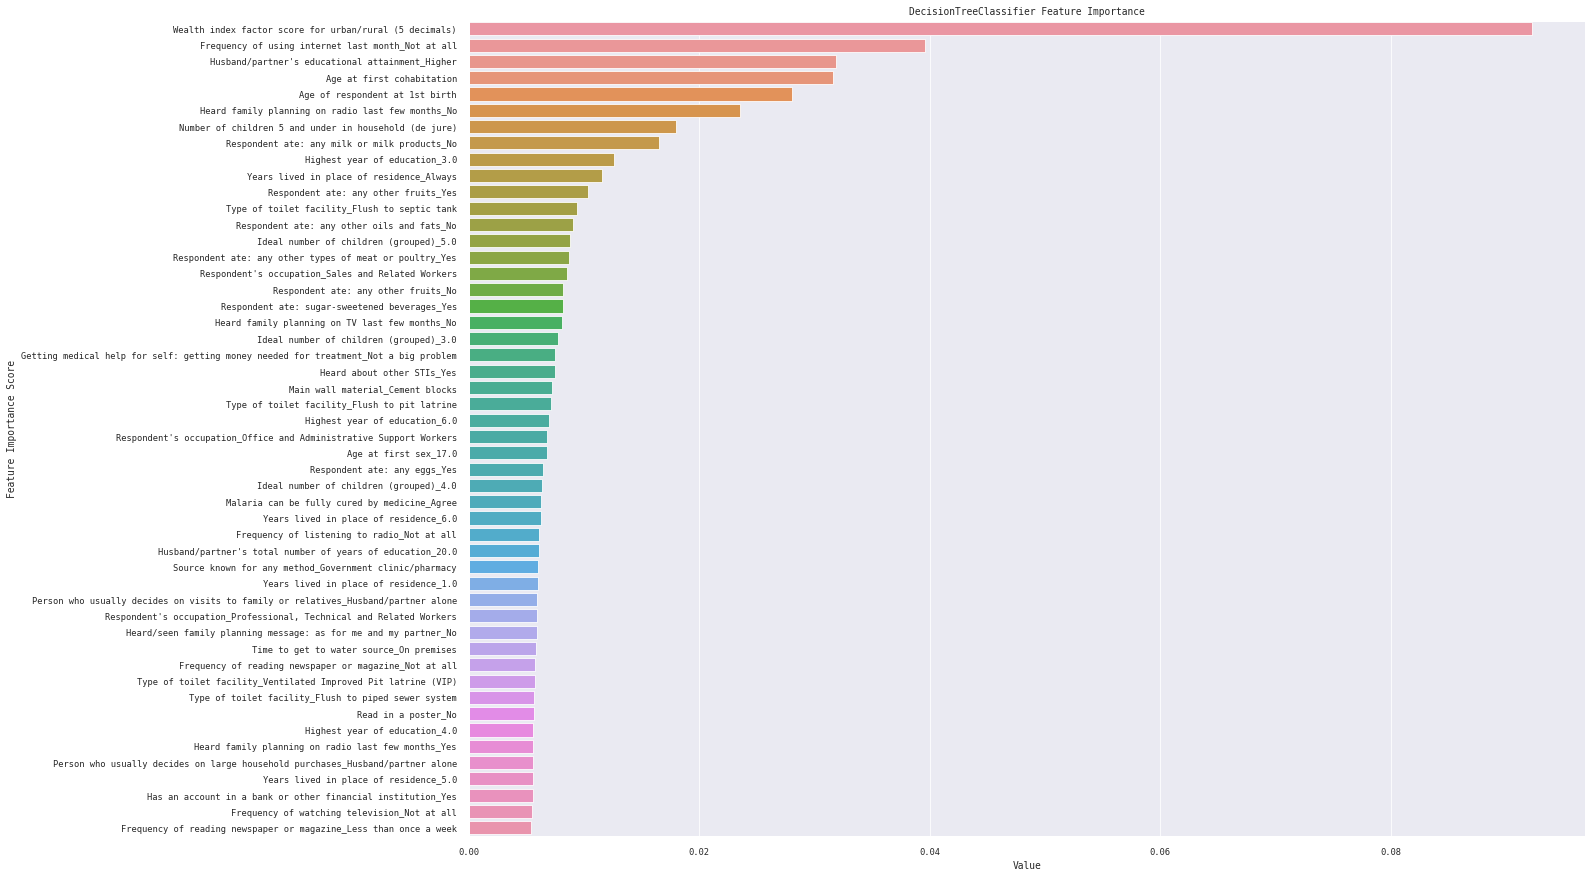

In [85]:
importance_plot(dtree_1, X)

### Catboost

In [86]:
!pip install catboost --quiet

     |████████████████████████████████| 67.4 MB 25 kB/s 


In [87]:
from catboost import CatBoostClassifier

cb_ = CatBoostClassifier(silent=True) 

Train and evaluate CatBoost Model

In [88]:
cb_matrix, cb_report, cb_1 = fit_predict(cb_, X, y, 'actual')

Fold 1 F1-score: 0.6104084451197608
Fold 2 F1-score: 0.5502972940177162
Fold 3 F1-score: 0.5702434558397639
Fold 4 F1-score: 0.5809893755997179
Fold 5 F1-score: 0.588903743315508
Fold 6 F1-score: 0.5579627309740056
Fold 7 F1-score: 0.5802404934905778
Fold 8 F1-score: 0.5562542359757536
Fold 9 F1-score: 0.6203144432148718
Fold 10 F1-score: 0.5858709665364997

Avg F1 score: 0.5801 


Classification report

In [89]:
print(cb_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     40704
           1       0.62      0.10      0.18      1117

    accuracy                           0.97     41821
   macro avg       0.80      0.55      0.58     41821
weighted avg       0.97      0.97      0.97     41821



Confusion matrix heatmap

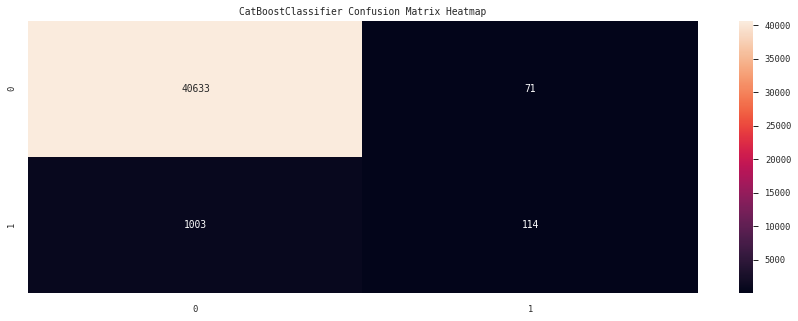

In [90]:
heat_map(cb_1, cb_matrix)

Feature Importance plot

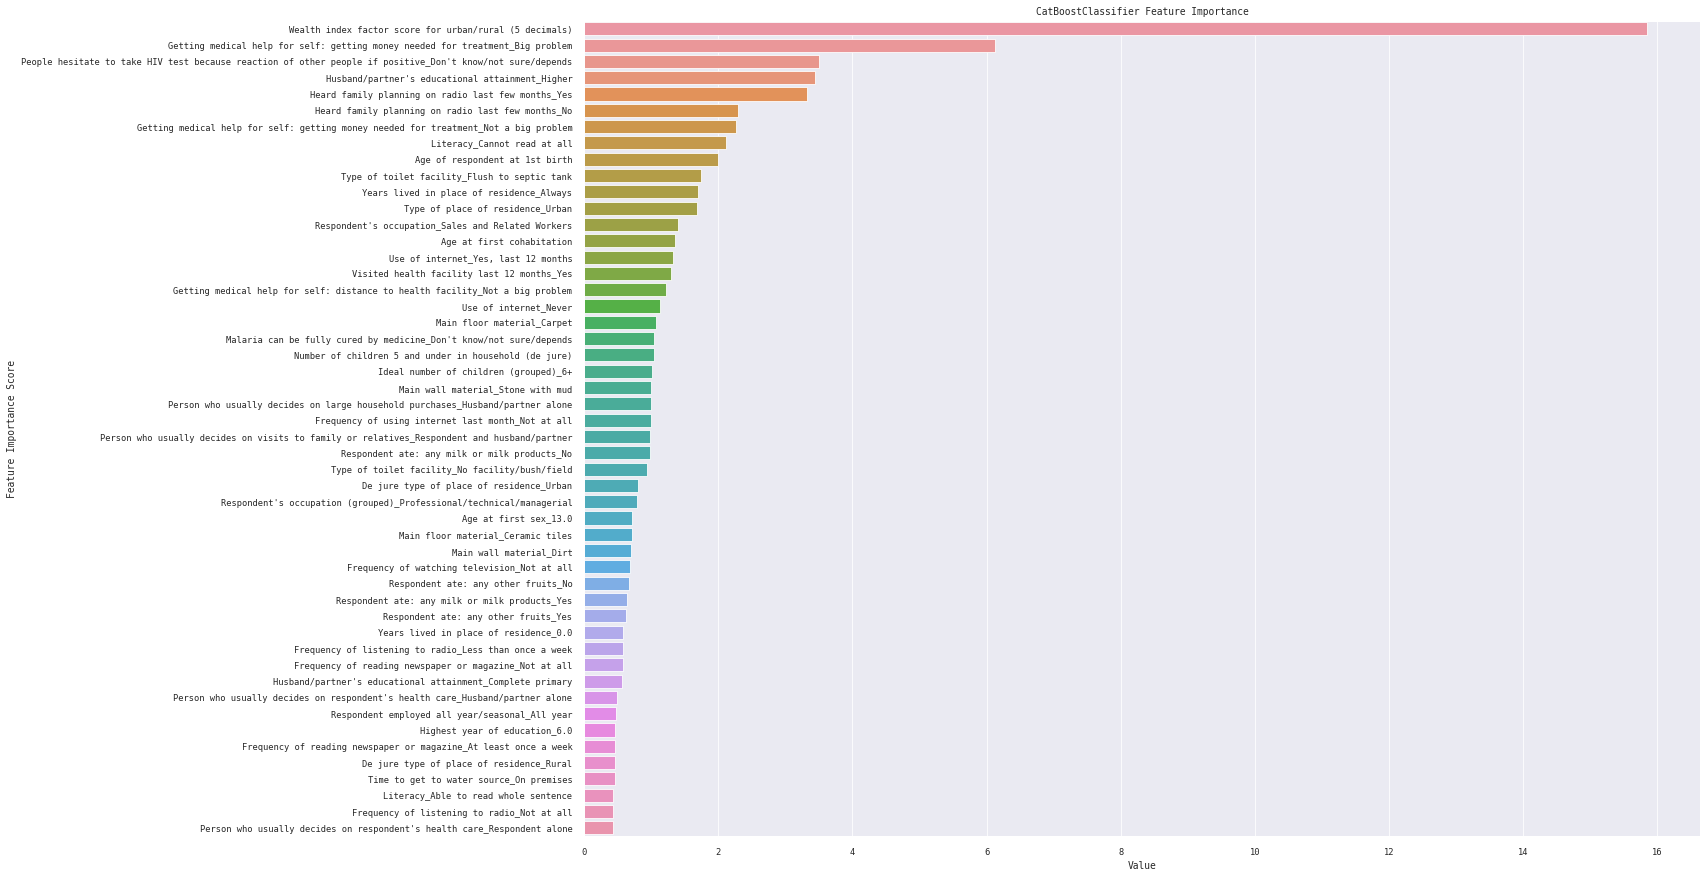

In [91]:
importance_plot(cb_1, X)

## Combine Oversampling and Random Undersampling


Since the dataset is imbalanced, we try to tackle this imbalance by oversampling the minority class and undersampling the majority class using random undersampling. Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class.

In [92]:
# load imblearn libraries
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline 

Grid search different oversampling methods for imbalanced classification

In [93]:
# methods to evaluate
methods = [SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE]

for method in methods:
  # define pipeline
  model = RandomForestClassifier() 
  over = method(sampling_strategy=0.1, random_state=1)
  under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
  steps = [('over', over), ('under', under), ('model', model)]
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline 
  kf = StratifiedKFold(n_splits=K, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=kf, n_jobs=-1)
  score = np.mean(scores) 
  print('> OverSampling method: {}, Mean ROC AUC: {:.4f}'.format(type(over).__name__,
                                                                 score)) 

> OverSampling method: SMOTE, Mean ROC AUC: 0.8604
> OverSampling method: ADASYN, Mean ROC AUC: 0.8595
> OverSampling method: SVMSMOTE, Mean ROC AUC: 0.8604
> OverSampling method: BorderlineSMOTE, Mean ROC AUC: 0.8643


Similar roc_auc scores for the four different oversampling methods. We would use Synthetic Minority Oversampling TEchnique [SMOTE](https://arxiv.org/abs/1106.1813).

### Helper function

In [94]:
def fit_predict_sample(model, X, y, sampling, k=5):
    ''' Description: Train model specified on oversampled and undersampled 
                     dataset using StratifiedKFold 
        Arguements: model - machine learning model to be trained 
                  X - training dataset
                  y - target column
                  k - k_neighbors hyperparameter in SMOTE
        Returns average confusion matrix, classification report and model name
    ''' 
    # set initial scores
    scores = 0
    auc_scores = 0
    # set empty list to store predictions on test set 
    test_oofs = []
    # get model name
    model_name = type(model).__name__ 
    # set a zero matrix of shape (2,2) for confusion matrix
    matrix = np.zeros((2,2))
    # set up empty lists to extend true and predicted values
    originalclass = []
    predictedclass = []

    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # oversampling and undersampling
        # define pipeline
        over = SMOTE(sampling_strategy=0.1, k_neighbors=k, random_state=1)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # transform the dataset
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
        # summarize  new class distribution
        counter = Counter(y_train) 
        class_distribution = {k: v for k, v in counter.items()}
        
        # training 
        if model_name in ['LogisticRegression','RandomForestClassifier', 
                          'DecisionTreeClassifier']:
          model.fit(X_train, y_train)
        else:
          model.fit(X_train, y_train, 
                    eval_set=[(X_test, y_test)],
                    use_best_model=True)       
        
        # predicting on test set
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:,1]
        # append y_test and pred list to original class and predicted class
        # lists respectively
        originalclass.extend(y_test)
        predictedclass.extend(pred) 
        # get F1-score and roc_auc_score
        score = f1_score(y_test, pred, average='macro')
        roc = roc_auc_score(y_test, prob)
        # take mean of scores
        scores += score/K
        auc_scores += roc/K
        test_oofs.append(pred)
        # sum confusion matrix of each fold to matrix
        matrix += confusion_matrix(y_test,pred)

        print('Fold {} F1-score: {}'.format(i+1, score))

    print()
    print('Avg F1 score: {:.4f} '.format(scores))
    # get classification report
    report = classification_report(originalclass, predictedclass)

    # append results for comaprison
    Model.append(model_name) # model name
    Resample.append(sampling) # sampling style
    F1score.append(scores) # f1-score
    AUCROC.append(auc_scores) # roc_auc_score
    return matrix, report, model

### Logistic Regression

Train and evaluate LogisticRegression Model

In [95]:
log_reg = LogisticRegression()
log_matrix, log_report, log_model_2 = fit_predict_sample(log_reg, X, y, 'smote')

Fold 1 F1-score: 0.5167648617103067
Fold 2 F1-score: 0.5776417346110616
Fold 3 F1-score: 0.5232973801521565
Fold 4 F1-score: 0.577230093540991
Fold 5 F1-score: 0.5213094196479521
Fold 6 F1-score: 0.5701498323123279
Fold 7 F1-score: 0.519916547155183
Fold 8 F1-score: 0.5187871165266624
Fold 9 F1-score: 0.5190826722429391
Fold 10 F1-score: 0.566266881647553

Avg F1 score: 0.5410 


Classification report

In [96]:
print(log_report)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     40704
           1       0.09      0.54      0.16      1117

    accuracy                           0.85     41821
   macro avg       0.54      0.70      0.54     41821
weighted avg       0.96      0.85      0.90     41821



Confusion matrix heatmap

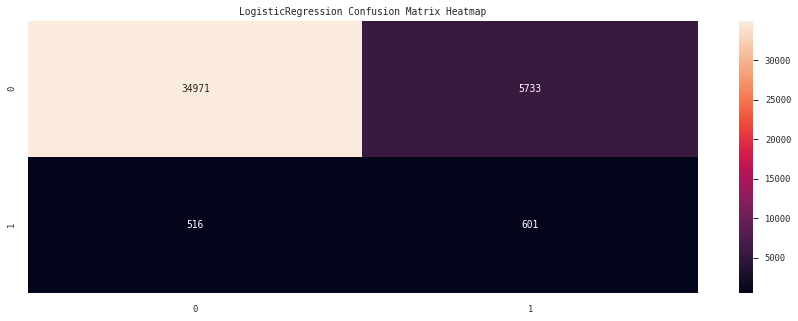

In [97]:
heat_map(log_model_2, log_matrix)

Feature Importance plot

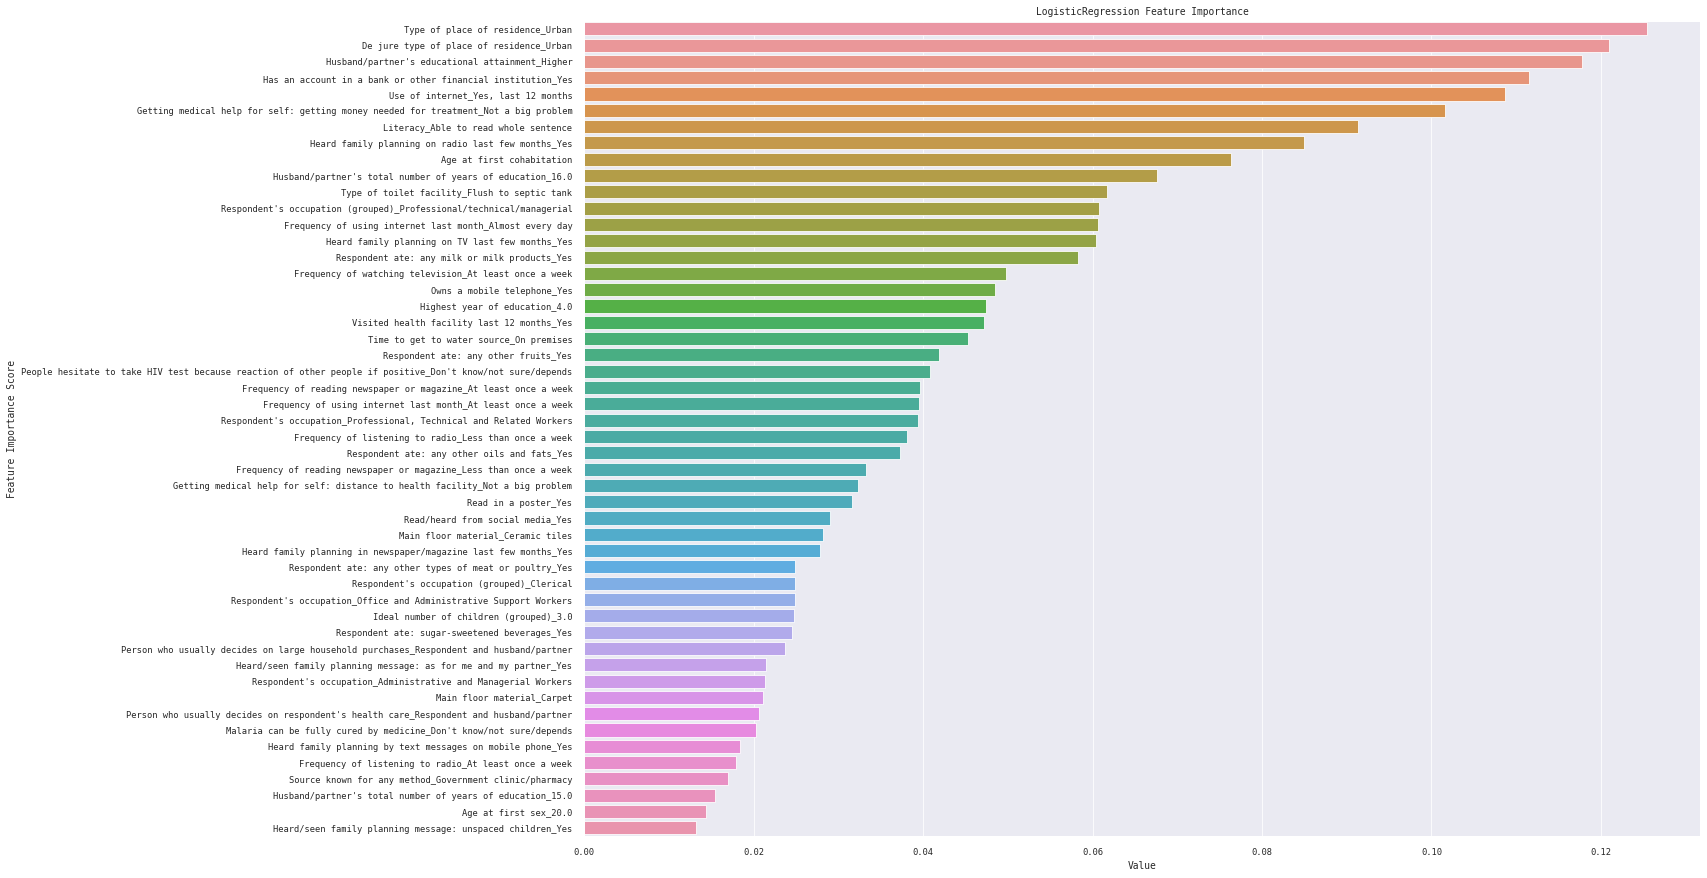

In [98]:
importance_plot(log_model_2, X)

### Decision Tree Classifier 

In [99]:
dtree = DecisionTreeClassifier() 
dtree_matrix, dtree_report, dtree_2 = fit_predict_sample(dtree, X, y, 'smote') 

Fold 1 F1-score: 0.5737772272634067
Fold 2 F1-score: 0.5681878379856734
Fold 3 F1-score: 0.5798406640009693
Fold 4 F1-score: 0.5640192330228114
Fold 5 F1-score: 0.5745676500508646
Fold 6 F1-score: 0.571163505077388
Fold 7 F1-score: 0.5763813420806139
Fold 8 F1-score: 0.56088063247804
Fold 9 F1-score: 0.5672025148464626
Fold 10 F1-score: 0.5812283180474107

Avg F1 score: 0.5717 


Classification report

In [100]:
print(dtree_report)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     40704
           1       0.13      0.44      0.20      1117

    accuracy                           0.90     41821
   macro avg       0.55      0.68      0.57     41821
weighted avg       0.96      0.90      0.93     41821



Confusion matrix heatmap

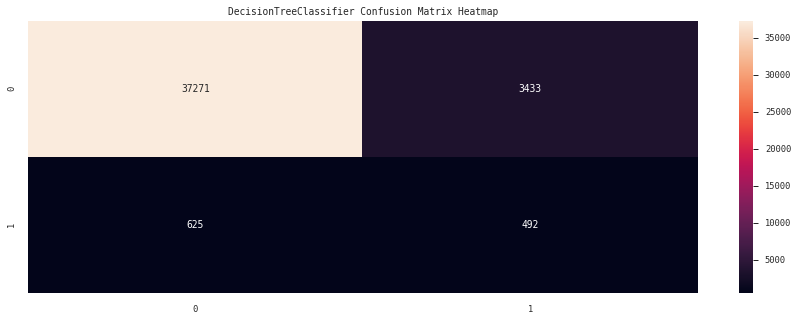

In [101]:
heat_map(dtree_2, dtree_matrix)

Feature Importance plot

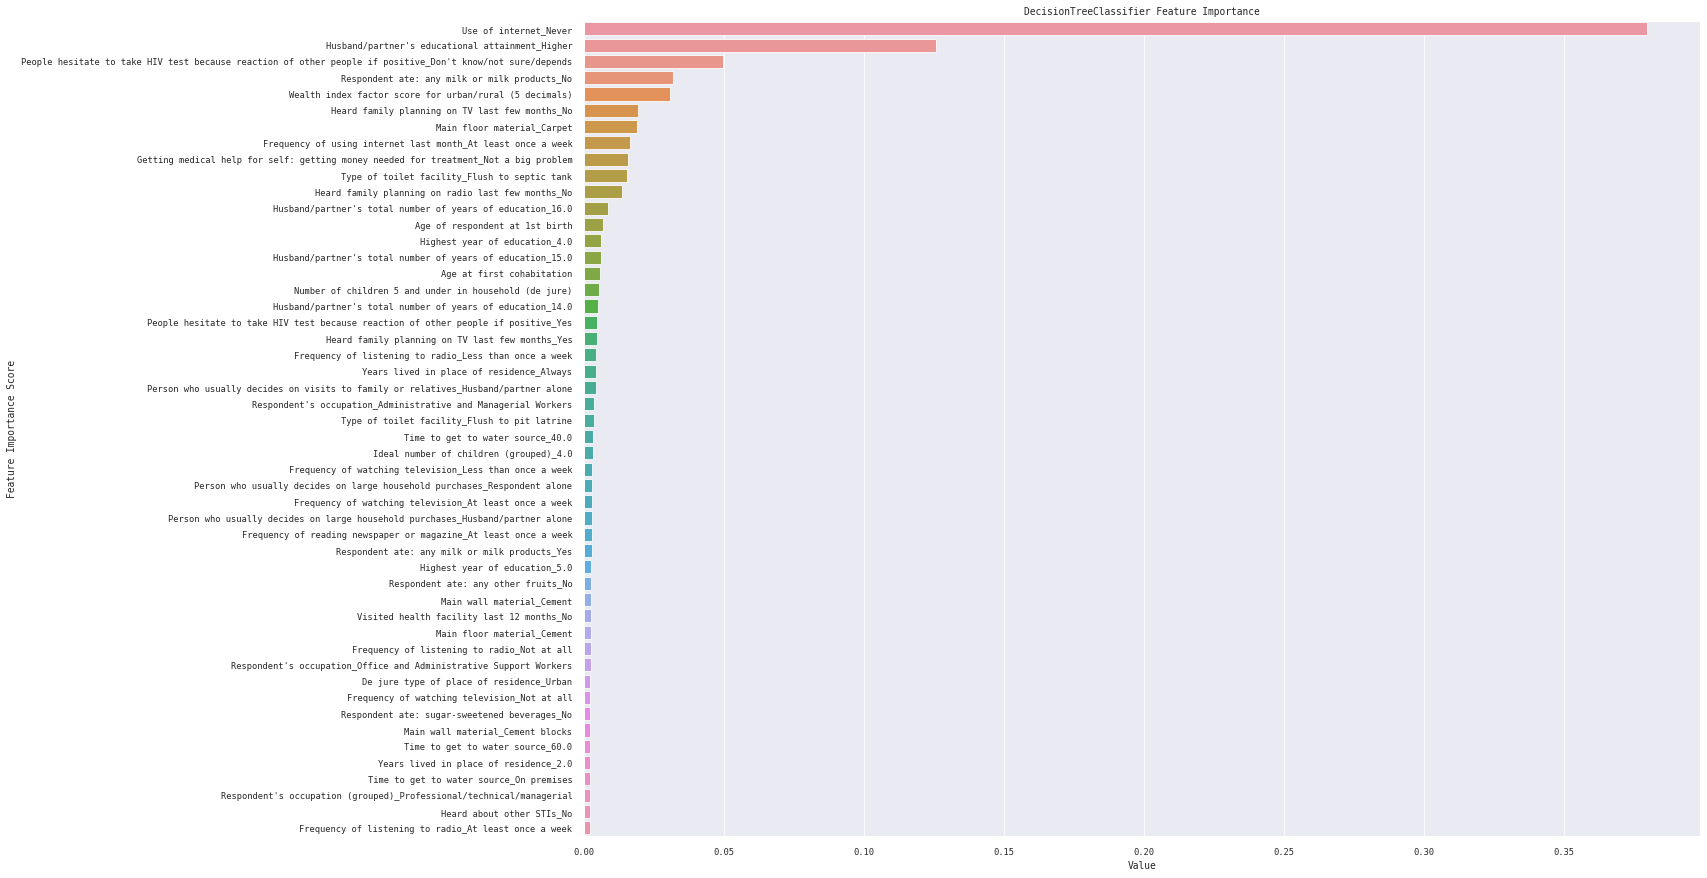

In [102]:
importance_plot(dtree_2, X)

### Random Forest Classifier

Train and evaluate RandomForest Model

In [103]:
rf = RandomForestClassifier() 
rf_matrix, rf_report, rf_2 = fit_predict_sample(rf, X, y, 'smote')

Fold 1 F1-score: 0.6751987593955358
Fold 2 F1-score: 0.6805830725646675
Fold 3 F1-score: 0.6760872884675391
Fold 4 F1-score: 0.664302739894336
Fold 5 F1-score: 0.6336725831236221
Fold 6 F1-score: 0.6694356689865284
Fold 7 F1-score: 0.6519223269460797
Fold 8 F1-score: 0.6559648122148122
Fold 9 F1-score: 0.6712882795547817
Fold 10 F1-score: 0.6646099416492179

Avg F1 score: 0.6643 


Classification report

In [104]:
print(rf_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40704
           1       0.33      0.36      0.35      1117

    accuracy                           0.96     41821
   macro avg       0.66      0.67      0.66     41821
weighted avg       0.97      0.96      0.96     41821



Confusion matrix heatmap

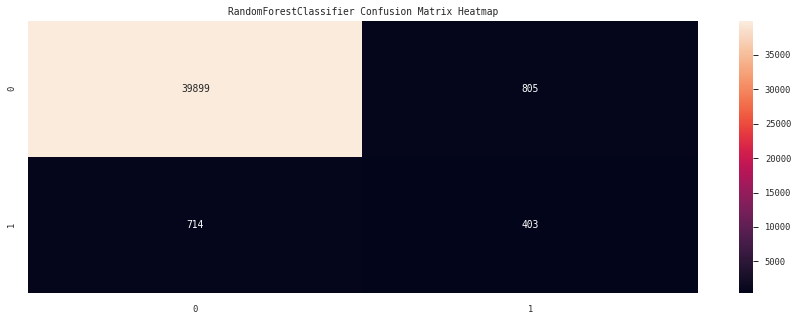

In [105]:
heat_map(rf_2, rf_matrix)

Feature Importance plot

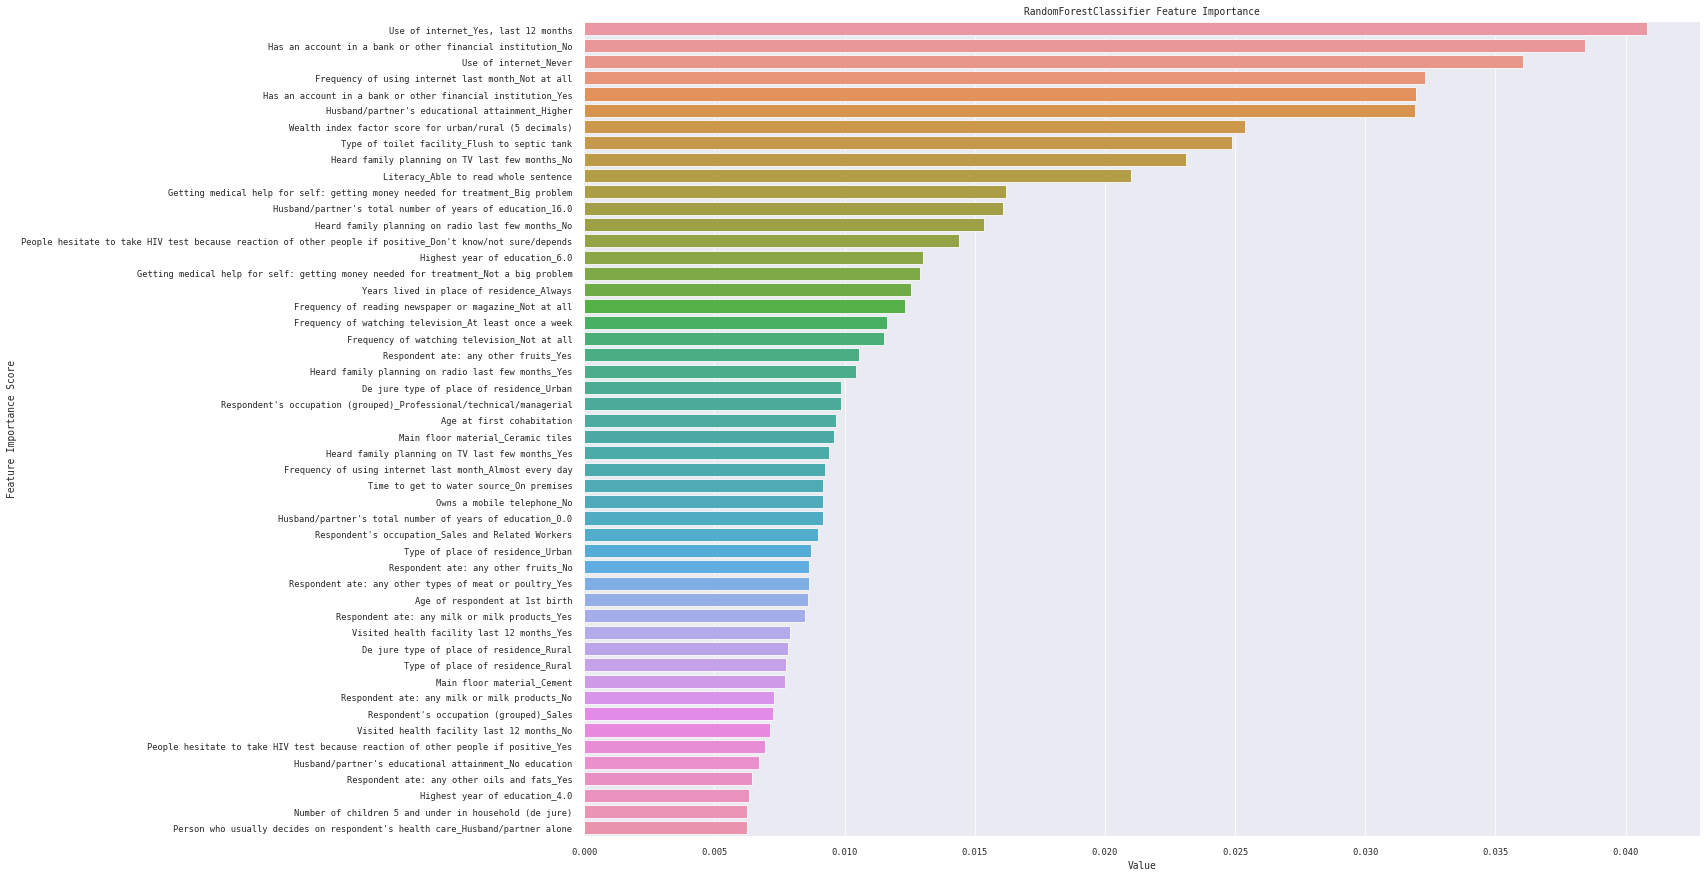

In [106]:
importance_plot(rf_2, X)

Save Model

In [124]:
pickle.dump(rf_2, open('insurance_rf.pkl', 'wb'))

### Catboost

Train and evaluate CatBoost Model

In [108]:
cb_ = CatBoostClassifier(silent=True)
cb_matrix, cb_report, cb_2 = fit_predict_sample(cb_, X, y, 'smote')

Fold 1 F1-score: 0.6815669095542098
Fold 2 F1-score: 0.6691637774475813
Fold 3 F1-score: 0.6675364758698092
Fold 4 F1-score: 0.6524515346005813
Fold 5 F1-score: 0.6374708590948168
Fold 6 F1-score: 0.6748868085549931
Fold 7 F1-score: 0.653966265523322
Fold 8 F1-score: 0.6593745710128216
Fold 9 F1-score: 0.6814693462796793
Fold 10 F1-score: 0.6583756397556546

Avg F1 score: 0.6636 


Classification report

In [109]:
print(cb_report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     40704
           1       0.29      0.44      0.35      1117

    accuracy                           0.96     41821
   macro avg       0.64      0.70      0.66     41821
weighted avg       0.97      0.96      0.96     41821



Confusion matrix heatmap

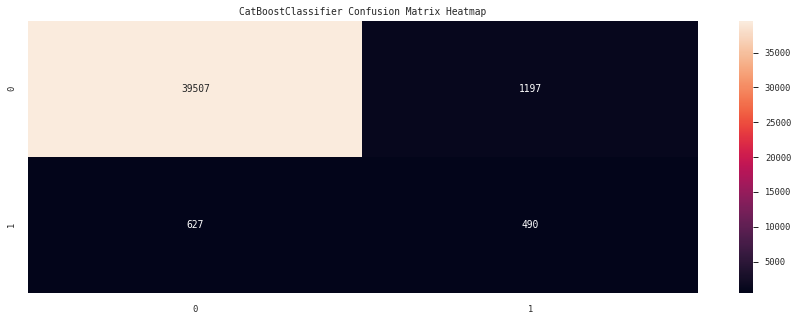

In [110]:
heat_map(cb_2, cb_matrix)

Feature Importance plot

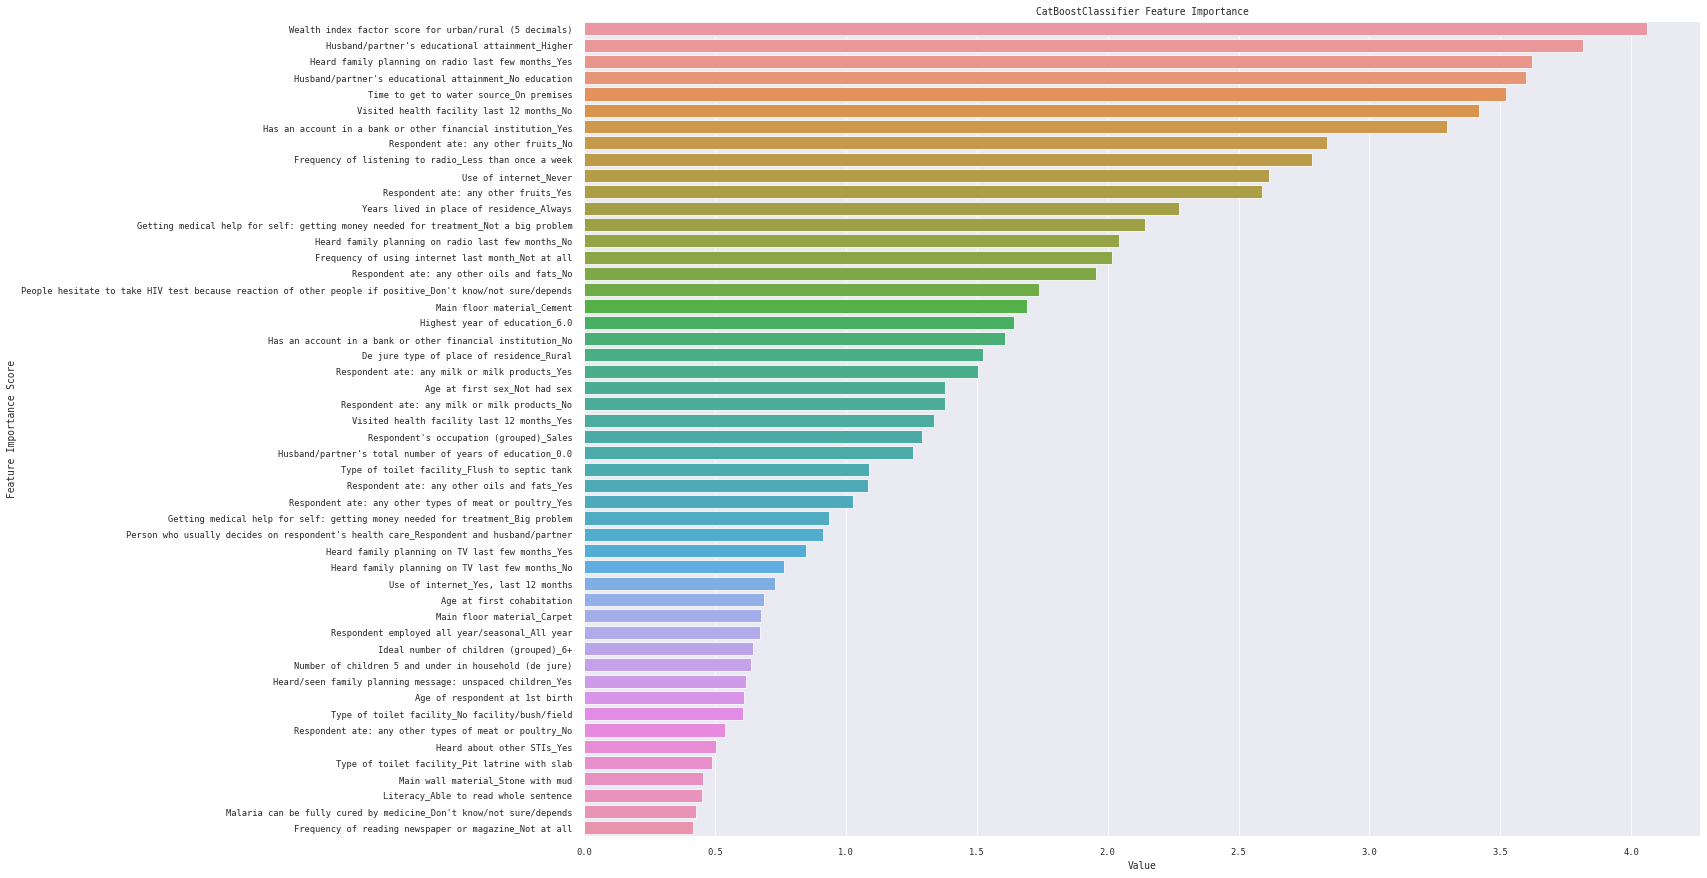

In [111]:
importance_plot(cb_2, X)

Save Model

In [112]:
# pickle.dump(cb_2, open('insurance_cb.pkl', 'wb')) 

## Model Comparison

In [113]:
eval_df = pd.DataFrame({'model':Model,
                        'resample':Resample,
                        'f1-score':F1score,
                        'AUC-ROC':AUCROC})
eval_df 

,model,resample,f1-score,AUC-ROC
0,LogisticRegression,actual,0.495850,0.720992
1,RandomForestClassifier,actual,0.525135,0.897434
2,DecisionTreeClassifier,actual,0.589442,0.595694
3,CatBoostClassifier,actual,0.580149,0.908791
4,LogisticRegression,smote,0.541045,0.797340
5,DecisionTreeClassifier,smote,0.571725,0.678072
6,RandomForestClassifier,smote,0.664307,0.907574
7,CatBoostClassifier,smote,0.663626,0.908627


In [114]:
# eval_df.to_csv('model_comparison.csv', index = False) 

Plotting F1-Score values of actual and resampled dataset.

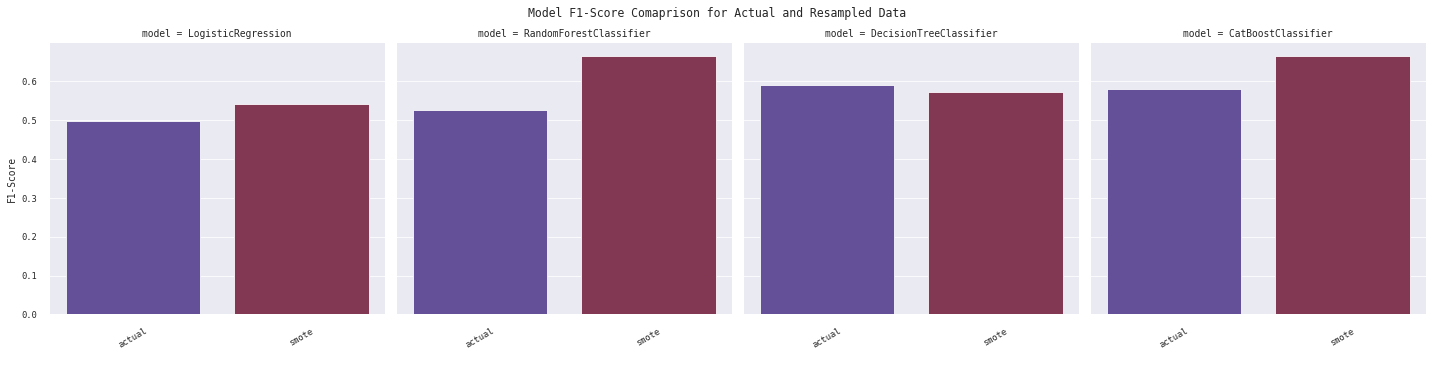

In [115]:
g = sns.FacetGrid(eval_df, col="model", height=5)
g.map(sns.barplot, 'resample', 'f1-score', palette='twilight', 
      order=['actual', 'smote'])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ')
g.set_ylabels('F1-Score')
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Model F1-Score Comaprison for Actual and Resampled Data')
plt.savefig('model_comprison.png');

Plotting ROC-AUC score values of actual and resampled dataset.

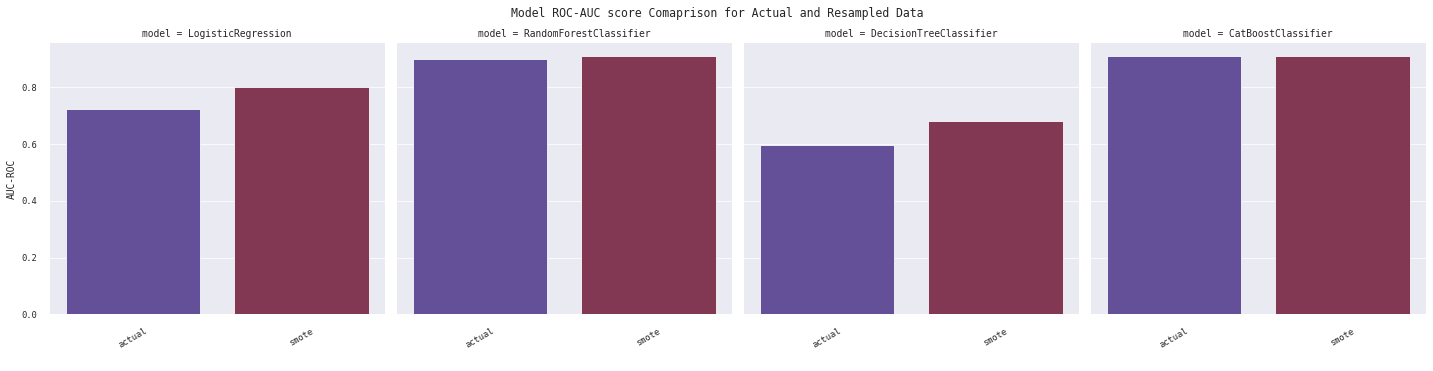

In [116]:
g = sns.FacetGrid(eval_df, col="model", height=5)
g.map(sns.barplot, 'resample', 'AUC-ROC', palette='twilight', 
      order=['actual', 'smote'])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ')
g.set_ylabels('AUC-ROC')
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Model ROC-AUC score Comaprison for Actual and Resampled Data');
# plt.savefig('model_comprison.png');

## Hyperparameter Optimization

In [117]:
!pip install optuna --quiet

     |████████████████████████████████| 302 kB 38.1 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 208 kB 53.1 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 111 kB 45.1 MB/s 
     |████████████████████████████████| 141 kB 36.2 MB/s 


In [118]:
import optuna 
import pickle

In [119]:
def objective(trial):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # parameters for model
        params = {
                'n_estimators': trial.suggest_int('n_estimators', 2, 20),
                'max_depth': int(trial.suggest_loguniform('max_depth', 1, 32))
            }
        # oversampling and undersampling
        # define pipeline
        over = SMOTE(sampling_strategy=0.1, random_state=1)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # transform the dataset
        X_sample, y_sample = pipeline.fit_resample(X, y)
        # model
        model = RandomForestClassifier(**params)
        model.fit(X_sample, y_sample)
        pred = model.predict(X_test)        
        # get F1-score
        score = f1_score(y_test, pred, average='macro')        
        return score
         
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-09-13 11:50:06,377] A new study created in memory with name: no-name-6f14db16-d097-4f73-9e7f-dc0e9c140226
[I 2021-09-13 11:50:07,420] Trial 0 finished with value: 0.6156866804692892 and parameters: {'n_estimators': 6, 'max_depth': 2.788421562960863}. Best is trial 0 with value: 0.6156866804692892.
[I 2021-09-13 11:50:08,578] Trial 1 finished with value: 0.8494006926743325 and parameters: {'n_estimators': 18, 'max_depth': 17.662500808836118}. Best is trial 1 with value: 0.8494006926743325.
[I 2021-09-13 11:50:09,437] Trial 2 finished with value: 0.6267453854063987 and parameters: {'n_estimators': 18, 'max_depth': 4.819678486221102}. Best is trial 1 with value: 0.8494006926743325.
[I 2021-09-13 11:50:10,174] Trial 3 finished with value: 0.7610525159305648 and parameters: {'n_estimators': 5, 'max_depth': 26.70503954803109}. Best is trial 1 with value: 0.8494006926743325.
[I 2021-09-13 11:50:10,971] Trial 4 finished with value: 0.8069988244389608 and parameters: {'n_estimators': 7,

Number of finished trials: 100
Best trial:
  Value: 0.8844714906864788
  Params: 
    n_estimators: 20
    max_depth: 27.753866975239013


Train and evaluate RandomForest Model with tuned parameters

In [120]:
rf_opt = RandomForestClassifier(n_estimators= 20,                           
                            max_depth= 25.0508989682803) 
rf_matrix, rf_report, rf_1 = fit_predict_sample(rf_opt, X, y, 
                                                'smote_optimized')

Fold 1 F1-score: 0.649023292483492
Fold 2 F1-score: 0.6898195494664878
Fold 3 F1-score: 0.6746585927397736
Fold 4 F1-score: 0.6280721493618368
Fold 5 F1-score: 0.623059866962306
Fold 6 F1-score: 0.6665004441573125
Fold 7 F1-score: 0.6398127617639813
Fold 8 F1-score: 0.6551681205717328
Fold 9 F1-score: 0.6607831345251426
Fold 10 F1-score: 0.6301630391580153

Avg F1 score: 0.6517 


Classification report

In [121]:
print(rf_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40704
           1       0.30      0.35      0.32      1117

    accuracy                           0.96     41821
   macro avg       0.64      0.66      0.65     41821
weighted avg       0.96      0.96      0.96     41821



Confusion matrix heatmap

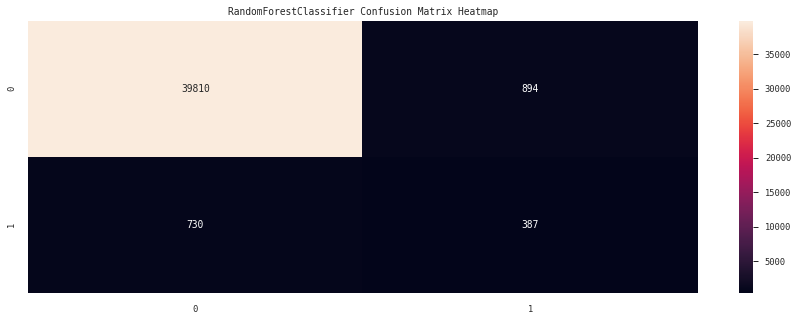

In [122]:
heat_map(rf_1, rf_matrix)

Feature Importance plot

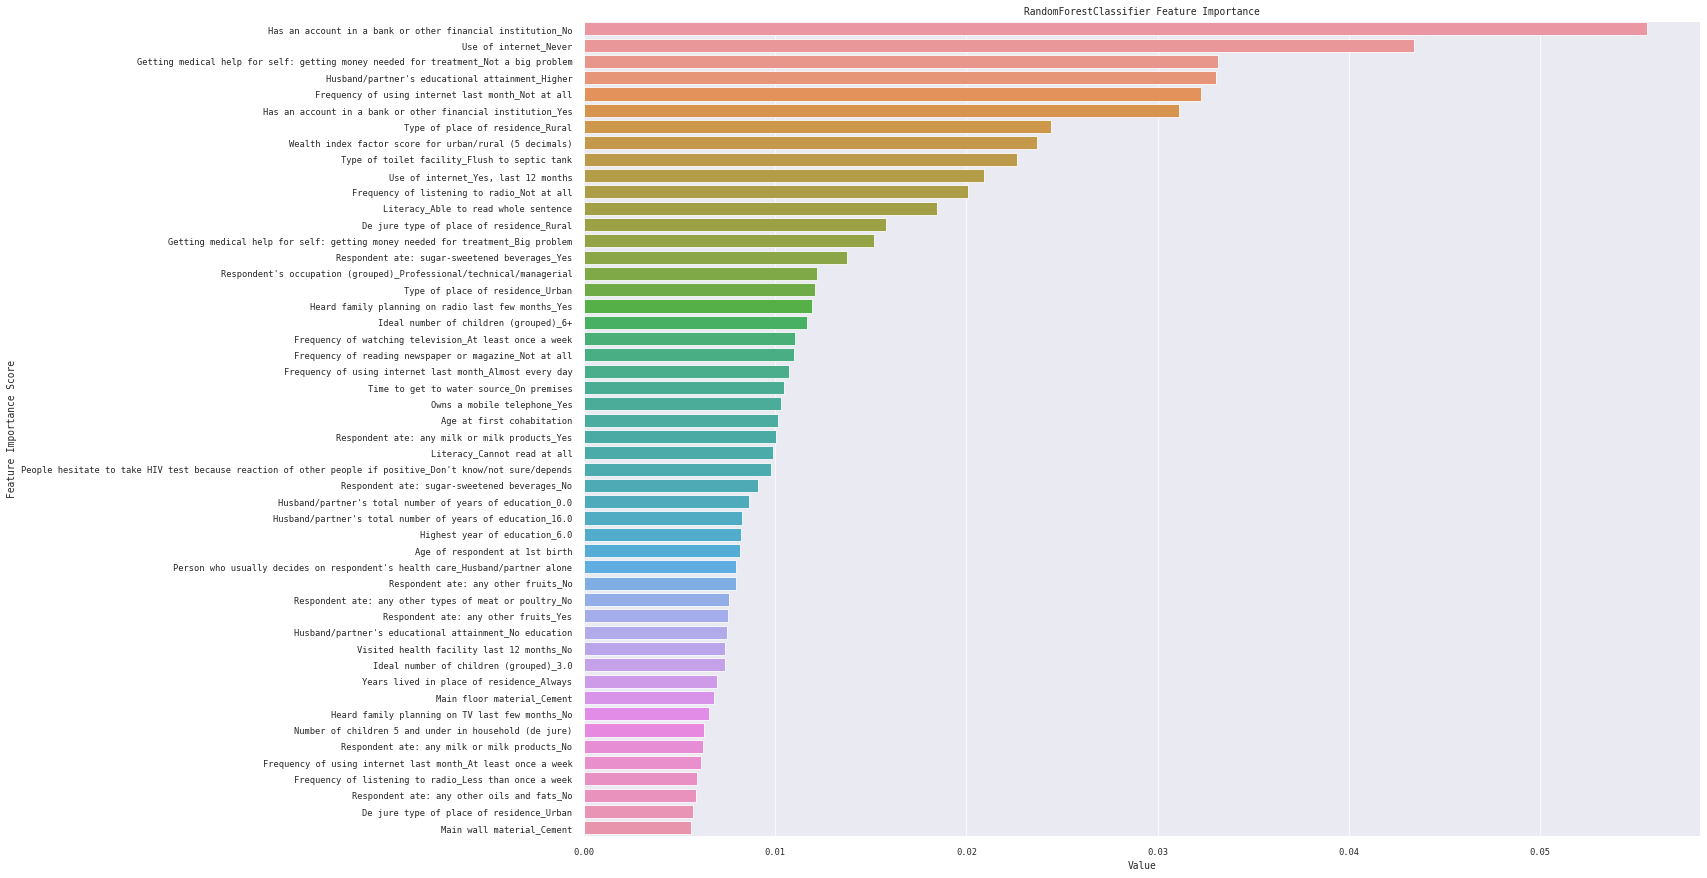

In [123]:
importance_plot(rf_opt, X)

No F1-score improvement compared to base RandomForestClassifier, we would try to tune more hyperparameters to improve the F1-score